# ¿Podemos detectar patrones entre consumidores específicos para identificar posibles fraudes?

<p>The famous statistician George E.P. Box once stated:</p>
<p>$$
\textbf{"All models are wrong, but some models are useful."}
$$</p>

## Metas (2 min)

Al final de este caso, estará familiarizado con $k$-means como algoritmo de agrupamiento. Específicamente, aprenderá el algoritmo detrás de $k$-means para intuir mejor cuándo funciona bien y cuándo no.

Durante el estudio de caso, realizará EDA en su conjunto de datos y observará una agrupación natural en los datos. Luego se le presentará $k$-means como una forma de automatizar este proceso. Luego, lo implementará y ajustará el algoritmo para validar sus hallazgos. Ser capaz de analizar algoritmos y ajustar sus datos al algoritmo es una habilidad importante para cualquier científico de datos.

## Introducción (5 min)

**Contexto empresarial.** Usted trabaja para el equipo de fraude de una gran compañía de seguros que se ocupa de la emisión de pólizas de seguro para diversos tipos de reclamaciones tanto para particulares como para empresas. Se realiza un seguimiento de las pólizas emitidas y se examinan y evalúan todos los reclamos presentados para determinar la legitimidad y la aprobación final del pago por parte de la compañía de seguros. Sin embargo, muchas personas intentan aprovecharse y presentan reclamaciones con falsos pretextos para obtener ingresos adicionales. La función del equipo antifraude es determinar qué reclamaciones presentadas deben aprobarse y cuáles deben rechazarse.

**Problema comercial.** Su tarea es responder la siguiente pregunta: **¿Existen patrones particulares en los grupos de reclamos presentados que puedan ser indicativos de fraude?**

**Contexto analítico.** El equipo de contabilidad le ha proporcionado datos sobre todas las reclamaciones recientes realizadas por 1000 personas. A diferencia de casos anteriores, los datos aquí no estarán etiquetados; es decir, ~~no hay ninguna variable que nos diga cuáles de estas afirmaciones son fraudulentas o no~~. Como resultado, los modelos de clasificación que hemos estado usando hasta ahora no se pueden utilizar. En su lugar, debemos utilizar **modelos de agrupación** para abordar este problema de **aprendizaje no supervisado**.

El caso se estructura de la siguiente manera:
Primero, realizar un análisis de datos exploratorio para investigar visualmente la estructura de los datos.
2. utilizar estas observaciones para guiar nuestra metodología de agrupación y ajustar los modelos apropiados
3. discutir las ventajas y limitaciones de los métodos típicos de agrupación; y finalmente
4. segmentar y generar conclusiones sobre grupos particulares

## Análisis exploratorio (15 min)

In [244]:
# Importing all the required packages

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn

from scipy.stats import norm
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler

%matplotlib inline

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [245]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>

Comencemos importando los datos disponibles y mirando las primeras filas:

In [246]:
# Download the data
!wget https://storage.googleapis.com/platzi-tf2/insurance_data_1000.xlsx

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


--2024-06-01 16:28:18--  https://storage.googleapis.com/platzi-tf2/insurance_data_1000.xlsx
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.207, 142.251.31.207, 142.251.18.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55246 (54K) [application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]
Saving to: ‘insurance_data_1000.xlsx.3’

insurance_data_1000 100%[===================>]  53.95K  --.-KB/s    in 0.02s   

2024-06-01 16:28:19 (2.20 MB/s) - ‘insurance_data_1000.xlsx.3’ saved [55246/55246]



In [247]:
# Importing the data, need the xlrd package

df_data = pd.read_excel('insurance_data_1000.xlsx')
df_data.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


case_id    income  age sex  approval         fraud    claims
0    59982  35750.95   42   M  Approved  Under Review   9518.95
1    87249  24078.27   19   M    Denied            No  19354.23
2    50406  39241.52   37   M    Denied         Fraud  13056.04
3    59391  33248.31   26   M  Approved            No  19238.37
4    96622  38649.96   54   M  Approved            No  14427.42
5    56519  39001.26   43   F    Denied            No  14659.06
6    89783  36862.26   46   F  Approved            No  11390.09
7    99992  42827.23   47   F    Denied            No  17272.75
8    40096  34838.49   25   M  Approved            No  13164.17
9     1710  34714.20   27   F  Approved            No  11267.48

# Preguntas:

### Vemos que el conjunto de datos contiene una columna "fraud". Realice un análisis exploratorio básico para comparar las afirmaciones fraudulentas/legítimas en los datos. ¿Que ves? ¿Ves alguna diferencia entre los grupos?

--------

Primero, podemos echar un vistazo a algunas estadísticas básicas de reclamaciones legítimas y fraudulentas:

In [248]:
df_data['claims']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0       9518.95
1      19354.23
2      13056.04
3      19238.37
4      14427.42
         ...   
995    15781.10
996    37004.41
997    33580.79
998    27975.41
999    22199.07
Name: claims, Length: 1000, dtype: float64

In [249]:
df_data['claims'].dtype

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


dtype('float64')

In [250]:
df_data['claims'] = pd.to_numeric(df_data['claims'], errors='coerce')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [251]:
#First we may check out the means across the different groups:
fraud_mean=df_data.groupby('fraud').mean(numeric_only=True)
fraud_stdev=df_data.groupby('fraud').std(numeric_only=True)
print(fraud_mean)
print(fraud_stdev)

                   case_id        income        age        claims
fraud                                                            
Fraud         43787.739130  46803.717304  40.921739  14024.738522
No            50252.966265  45854.392169  40.375904  13194.549181
Under Review  48235.000000  52175.336000  45.563636  12486.826727
                   case_id        income        age       claims
fraud                                                           
Fraud         28320.101889  22092.369036  13.408656  8859.365261
No            29228.962165  21573.767840  14.561326  7963.349915
Under Review  27787.708824  26182.524826  15.732443  8457.996444


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [252]:
fraud_mean=df_data['income'].mean()
fraud_stdev=df_data['income'].std()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [253]:
#First we may check out the means across the different groups:
df_data.groupby('fraud')["claims"].mean()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


fraud
Fraud           14024.738522
No              13194.549181
Under Review    12486.826727
Name: claims, dtype: float64

In [254]:
#First we may check out the means across the different groups:
df_data.groupby('fraud')["income"].mean()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


fraud
Fraud           46803.717304
No              45854.392169
Under Review    52175.336000
Name: income, dtype: float64

In [255]:
#First we may check out the means across the different groups:
df_data.groupby('fraud')["age"].mean()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


fraud
Fraud           40.921739
No              40.375904
Under Review    45.563636
Name: age, dtype: float64

Vemos algunas ligeras diferencias en los ingresos entre los grupos. Parece que los reclamos fraudulentos tienden a ser alrededor de $800 más grandes que los reclamos legítimos. Las edades parecen ser las mismas, excepto en los grupos analizados (que parecen ser mayores).


Sin embargo, observe que las desviaciones estándar son bastante grandes.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


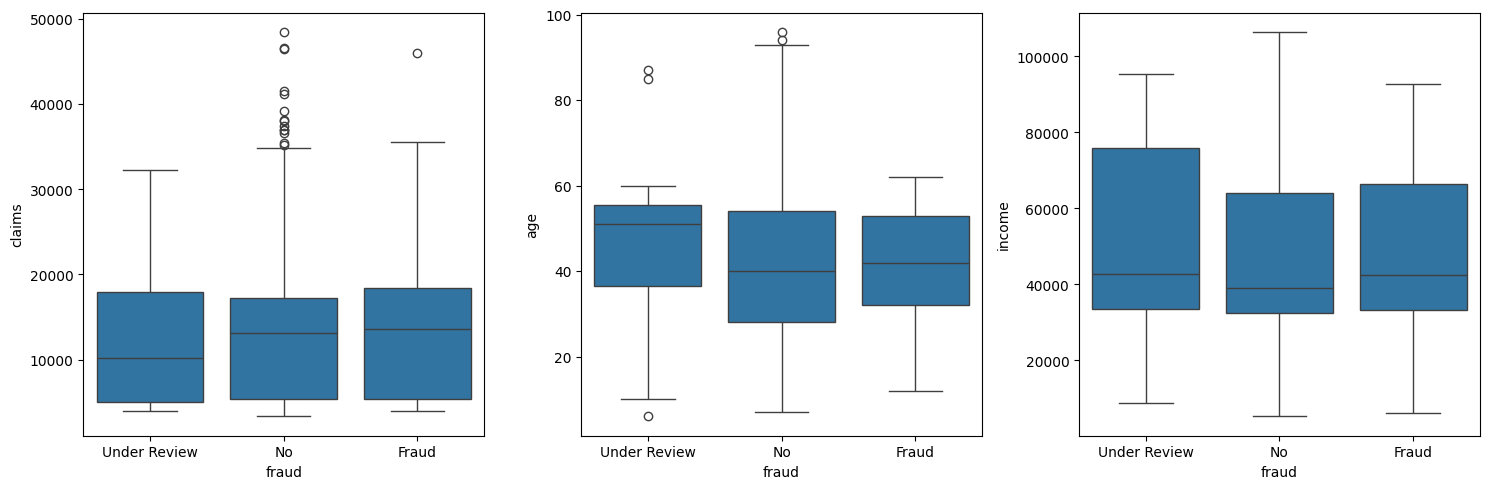

In [256]:
fig, ax=plt.subplots(1,3, figsize=(15,5))
sns.boxplot(x='fraud', y='claims',data=df_data,ax=ax[0])
sns.boxplot(x='fraud', y='age',data=df_data, ax=ax[1])
sns.boxplot(x='fraud', y='income',data=df_data, ax=ax[2])
fig.tight_layout()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0

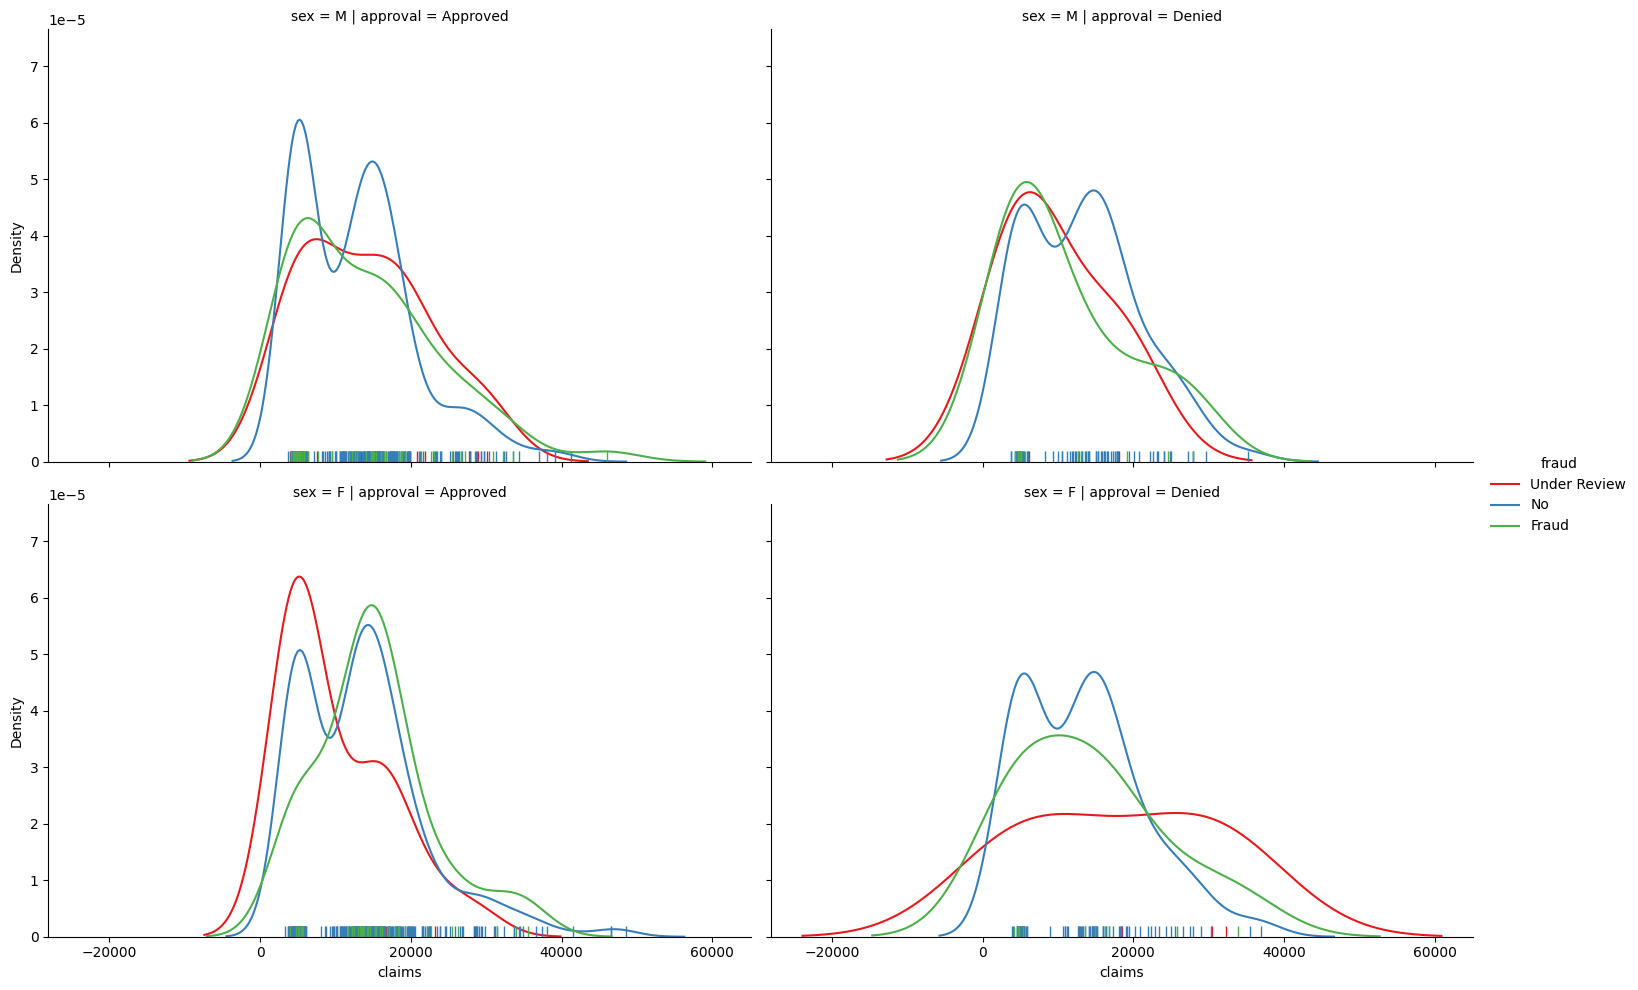

In [257]:
g = sns.FacetGrid(df_data, col='approval',row='sex', hue='fraud', palette="Set1",height=5, aspect=1.5 )
g = (g.map(sns.distplot, "claims", hist=False, rug=True))
g.add_legend()

Vemos algunas ligeras diferencias en las distribuciones. Vemos que las reclamaciones parecen ser bimodales. Tenga en cuenta que las reclamaciones fraudulentas en los hombres tienden a rondar los $\$5000$, pero para las mujeres rondan los $\$17000$. También vemos algunas diferencias entre el grupo de reclamaciones denegadas y aprobadas.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0

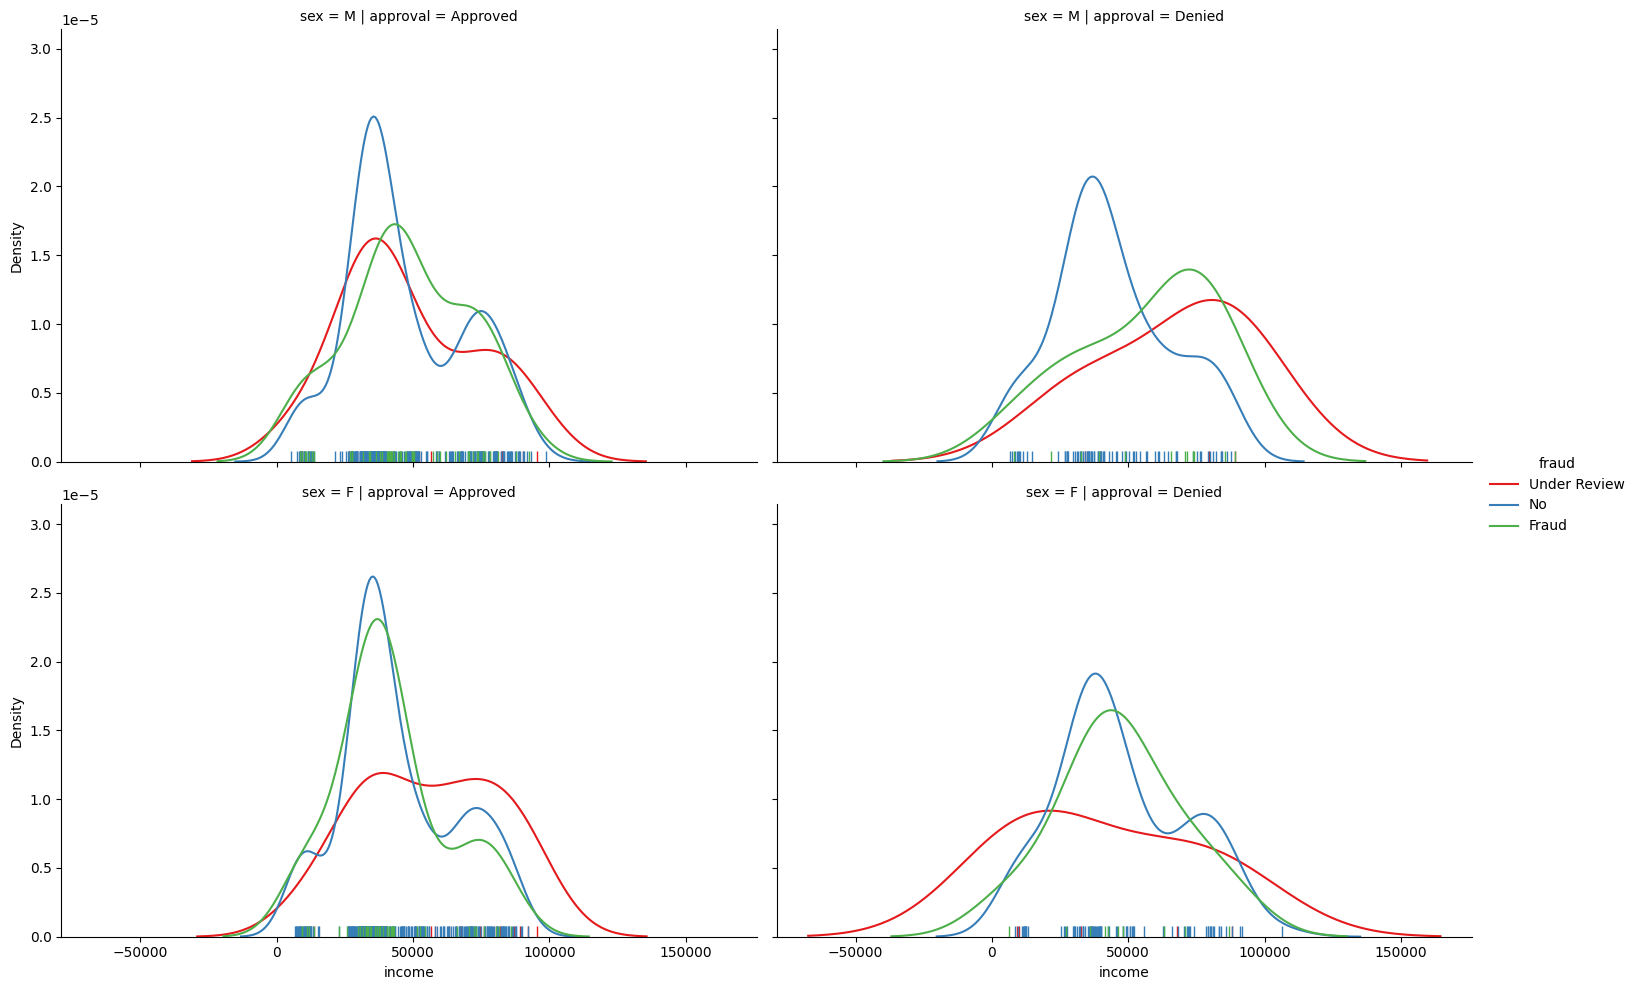

In [258]:
g = sns.FacetGrid(df_data, row='sex',col='approval', hue='fraud', palette="Set1",height=5, aspect=1.5 )
g = (g.map(sns.distplot, "income", hist=False, rug=True))
g.add_legend()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0

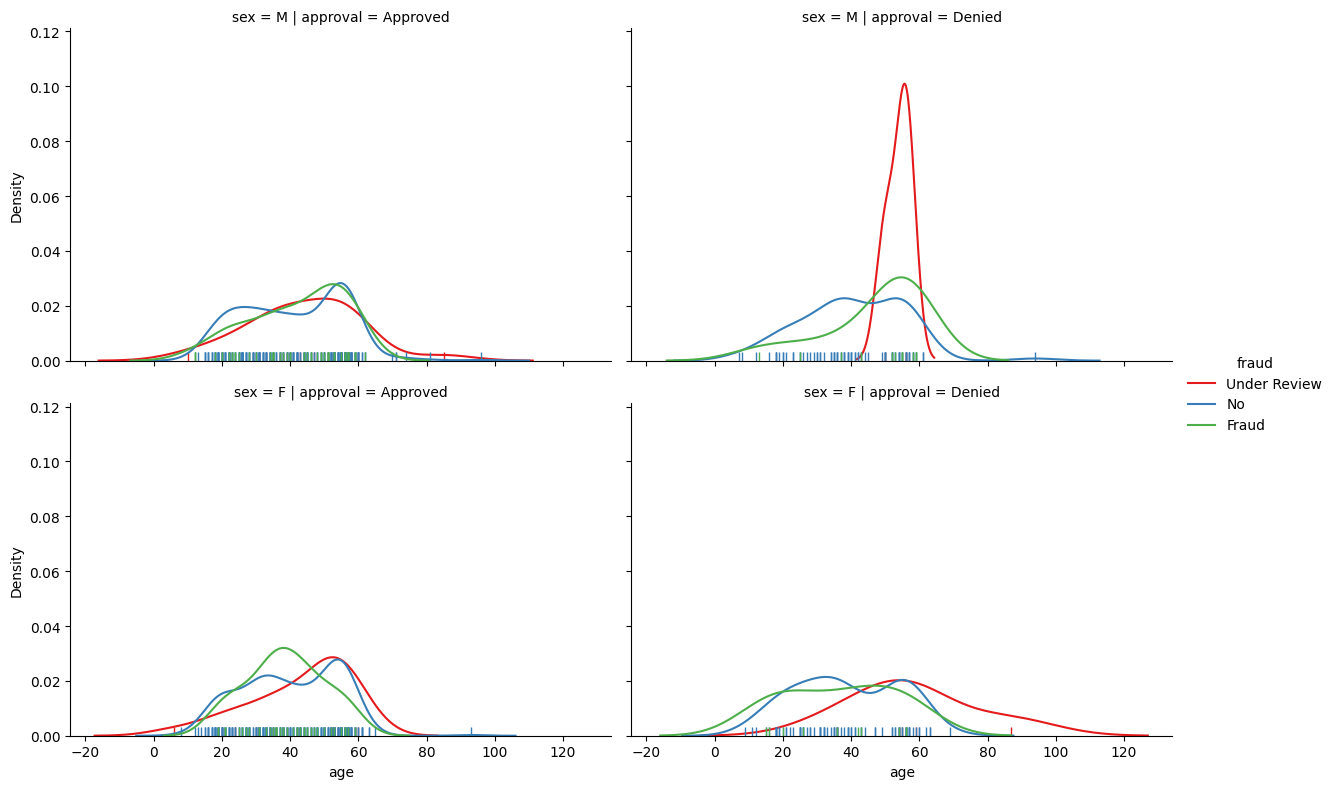

In [259]:
g = sns.FacetGrid(df_data, col='approval',row='sex', hue='fraud', palette="Set1",height=4, aspect=1.5 )
g = (g.map(sns.distplot, "age", hist=False, rug=True))
g.add_legend()

**Revisemos el gráfico "ingresos" versus "reclamo" y "ingresos versus edad" en todos los reclamos:**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


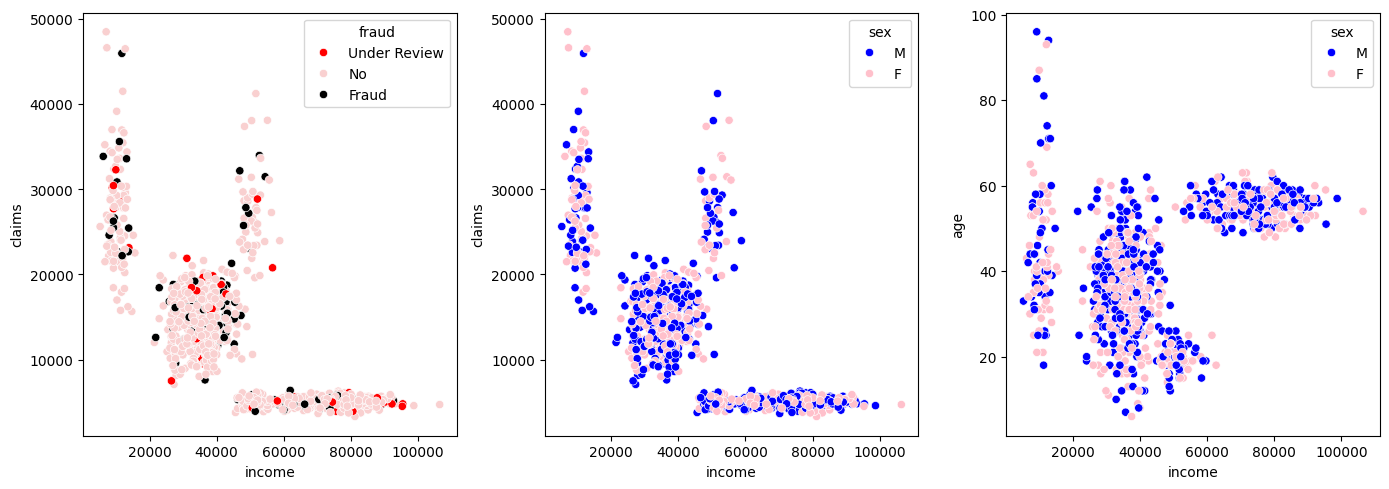

In [260]:
fig,ax=plt.subplots(1,3,figsize=(14,5))

sns.scatterplot(x='income', y='claims', hue='fraud', data=df_data, palette=['red','#F9D0D0','black'],ax=ax[0])
sns.scatterplot(x='income', y='claims', hue='sex', data=df_data,palette=['blue','pink'],ax=ax[1])
sns.scatterplot(x='income', y='age', hue='sex', palette=['blue','pink'],data=df_data,ax=ax[2])
fig.tight_layout()

### Ejercicio 1: (5 min)

¿Qué patrones notas en los gráficos de arriba? ¿Por qué crees que podrían estar sucediendo estas cosas?

**Respuesta.** No parece haber grandes diferencias en las distribuciones basadas en el género; sin embargo, los gráficos independientes del género muestran algunos grupos claros. Por ejemplo, hay un grupo gigante de reclamaciones en torno al rango de ingresos de \\$30 000 - \\$40 000 en el gráfico de reclamaciones versus ingresos, lo que podría deberse al hecho de que el ingreso medio es de aproximadamente \\$30 000 - \\$40 000. También hay una franja de reclamaciones de \\$50 000 a \\$100 000 en el cuadro de reclamaciones versus ingresos, que valen \\$5000 aproximadamente. No está claro exactamente qué son estos reclamos, pero podrían ser cosas cotidianas con las que pueden lidiar las personas más adineradas (por ejemplo, reclamos por accidentes automovilísticos). También hay una serie de reclamaciones por al menos \\$20.000 entre personas que ganan sólo \\$10.000, lo cual es inusual y bien puede consistir en reclamaciones fraudulentas.

En el gráfico de ingresos versus edad, hay una franja de personas que ganan \\$10 000 en todas las edades (salario mínimo), un gran grupo de personas que ganan entre \\$30 000 y \\$40 000 en todas las edades (salario medio) y una muchas personas con ingresos más altos (\\$60,000 - \\$100,0000) justo antes de los 60 años. La edad de 59 años y medio es cuando las personas en los EE. UU. pueden comenzar a retirar ahorros de sus cuentas de jubilación, por lo que esto puede tener algo que ver con este patrón. Además:

1. **¡Vemos que las reclamaciones se dividen en más o menos cuatro grupos!** Estos grupos no tienen etiquetas claras en los datos, por lo que tendríamos que encontrar formas de detectarlos de manera eficiente. Quizás el comportamiento de las reclamaciones fraudulentas cambie dentro de cada grupo.

2. **Los datos sobre fraude están desequilibrados**. ¡Hay más o menos una proporción de 1:8 cuando se trata de reclamos fraudulentos versus legítimos! ¡Por lo tanto, debemos tener mucho cuidado al sacar conclusiones con este conjunto de datos!


## ¿Cuál es el plan?
    
1. Intenta identificar los diferentes conjuntos de grupos que hemos observado. ¡Para esto aprenderemos un algoritmo de agrupamiento!
2. Intente sacar conclusiones dentro de cada grupo para obtener información parcial sobre el conjunto de reclamaciones fraudulentas.

    
Eso suena razonable ¿verdad?

In [261]:
df_data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


case_id    income  age sex  approval         fraud    claims
0      59982  35750.95   42   M  Approved  Under Review   9518.95
1      87249  24078.27   19   M    Denied            No  19354.23
2      50406  39241.52   37   M    Denied         Fraud  13056.04
3      59391  33248.31   26   M  Approved            No  19238.37
4      96622  38649.96   54   M  Approved            No  14427.42
..       ...       ...  ...  ..       ...           ...       ...
995    96947  11353.88   81   M  Approved            No  15781.10
996    87668   8799.08   37   M  Approved            No  37004.41
997    39658  13143.52   35   M  Approved         Fraud  33580.79
998    77914   9473.25   36   F    Denied            No  27975.41
999    97965  11818.86   36   F  Approved         Fraud  22199.07

[1000 rows x 7 columns]

In [262]:
# Let's find the groups across all of our data:

#df = df_data[['case_id', 'income', 'age', 'claims']]

df=df_data[['income', 'age', 'claims']]

#df['sex']=df_data['sex'].astype('category').cat.codes

df.head(5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


income  age    claims
0  35750.95   42   9518.95
1  24078.27   19  19354.23
2  39241.52   37  13056.04
3  33248.31   26  19238.37
4  38649.96   54  14427.42

<hora>

### Pregunta: (5 min)

¿Cómo harías para crear un algoritmo que encuentre los grupos que hemos determinado mediante la "observación" en las figuras anteriores? Discutir con un compañero.

<hora>

## $k$-means clustering (25 min)

En nuestras visualizaciones anteriores, parecen existir distintas poblaciones de individuos según las relaciones entre reclamaciones de ingresos, e ingresos y edad. Sin embargo, solo hemos logrado investigar dos relaciones de esta manera, y en conjuntos de datos más grandes con muchas características, hacerlo manualmente en todas las variables puede llevar mucho tiempo. Afortunadamente, los **modelos de agrupamiento** nos permiten resumir y detectar relaciones potencialmente interesantes con bastante rapidez.

Hay muchas variaciones de agrupación, pero la más común, y la que veremos, se llama **$k$-means clustering**. Este algoritmo separa el conjunto de datos dado en $k$ grupos que minimizan la suma de los cuadrados de las distancias entre cada par de puntos del grupo. El científico de datos necesita preseleccionar el valor de $k$, lo que puede requerir un análisis previo para determinarlo.

El método consta de 3 pasos amplios, que se pueden resumir de la siguiente manera:

1. Inicialización. Para comenzar, se deben seleccionar $k$ puntos (no necesariamente cualquiera de los puntos de datos, solo puntos en el mismo espacio dimensional) como los centroides "iniciales".
2. Asignación. Cada punto de datos se asigna al grupo correspondiente al centroide más cercano a él (generalmente según la distancia euclidiana estándar).
3. Actualización. Una vez que todos los puntos de datos se han asignado a sus respectivos grupos, se calcula un nuevo centroide para cada grupo tomando la media de todos los puntos de ese grupo.

Luego se repiten los pasos 2 y 3 hasta que los grupos ya no cambien.

## ¡Antes de pasar a la implementación, la siguiente nota es realmente importante!

### Ejercicio 2: (5 min)

La agrupación de $k$-means se basa en minimizar la distancia euclidiana entre puntos de datos. ¿Qué tipo de problemas podría plantear tener multiples tipos de datos con valores diferentes, por ejemplo dinero que gana mensual vs intereses? ¿Cómo podríamos solucionar esto?

**Respuesta.** Podría ocurrir un problema de escala. Si algunas variables naturalmente tienen valores muy pequeños mientras que otras tienen valores muy grandes, entonces las características de facto no se ponderan de manera uniforme en el cálculo de la distancia euclidiana. Para solucionar este problema, necesitaríamos escalar cada variable adecuadamente según una medida de su tamaño; por ejemplo, podríamos dividir todo por el valor mediano de dicha variable.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


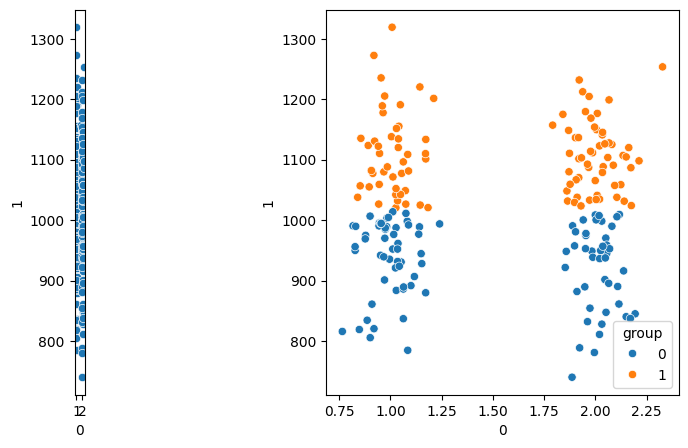

In [263]:
x1=np.random.normal(1,0.1, 100)
x2=np.random.normal(2,0.1, 100)
y1=np.random.normal(1000,100, 100)
y2=np.random.normal(1000,100, 100)
x=np.concatenate((x1,x2))
y=np.concatenate((y1,y2))
weird_data=pd.DataFrame([x,y]).T

k = 2
kmeans0 = KMeans(n_clusters=k, init='k-means++')
kmeans0.fit(weird_data)

# Iterative procedure to learn labels
weird_data['group'] = kmeans0.predict(weird_data)

fig,ax=plt.subplots(1,2,figsize=(10,5))
sns.scatterplot(x=0, y=1, data=weird_data,ax=ax[0])
sns.scatterplot(x=0, y=1, hue='group', data=weird_data,ax=ax[1])
ax[0].set_aspect(.1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<Axes: xlabel='x', ylabel='y'>

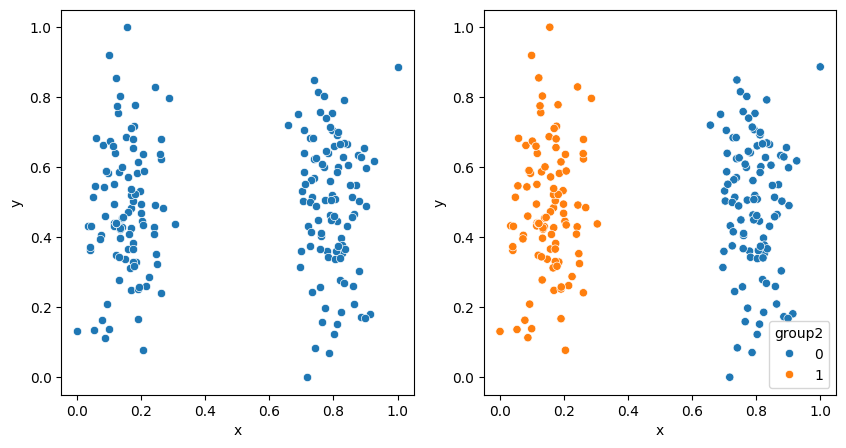

In [264]:
weird_data['x']=(weird_data[0]-weird_data[0].min())/(weird_data[0].max()-weird_data[0].min())
weird_data['y']=(weird_data[1]-weird_data[1].min())/(weird_data[1].max()-weird_data[1].min())
k = 2
kmeans1 = KMeans(n_clusters=k, init='k-means++')
kmeans1.fit(weird_data[['x','y']])

# Iterative procedure to learn labels
weird_data['group2'] = kmeans1.predict(weird_data[['x','y']])

fig,ax=plt.subplots(1,2,figsize=(10,5))
sns.scatterplot(x='x', y='y', data=weird_data,ax=ax[0])
sns.scatterplot(x='x', y='y', hue='group2', data=weird_data,ax=ax[1])

Hay muchas formas de escalar o **normalizar** variables, una de las cuales hemos mencionado anteriormente. La mejor opción de normalización depende de los detalles particulares del conjunto de datos en cuestión.

De manera similar, la distancia euclidiana es la métrica más utilizada para calcular los conglomerados, ya que es bastante fácil de calcular y funciona bien en la mayoría de los conjuntos de datos, pero no es la única. Los científicos de datos a veces utilizan variaciones en la métrica de distancia según el conjunto de datos que están investigando. Por lo tanto, es un parámetro que debe ser considerado y explorado durante la etapa EDA para determinar qué es mejor proceder.

### Ejercicio 3: (10 min)

Escriba una función que normalice `age`, `income`, and `claims` de acuerdo con los valores mínimo y máximo de cada variable. Por ejemplo, si estamos hablando de `age`, entonces un valor normalizado para una edad $A$ se calcularía como $\displaystyle\frac {X - min(age)} {max(age) - min(age)}$ (Esto se conoce como método de escala mínimo-máximo).

**Respuesta.** A continuación se muestra una posible solución:

In [265]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler

# Min-Max Scaling
min_max_scaler = MinMaxScaler()
df_min_max_scaled = pd.DataFrame(min_max_scaler.fit_transform(df), columns=df.columns)
print("Min-Max Scaled Data:")
print(df_min_max_scaled)

# Z-Score Standardization
standard_scaler = StandardScaler()
df_standard_scaled = pd.DataFrame(standard_scaler.fit_transform(df), columns=df.columns)
print("\nZ-Score Standardized Data:")
print(df_standard_scaled)

# Max Abs Scaling
max_abs_scaler = MaxAbsScaler()
df_max_abs_scaled = pd.DataFrame(max_abs_scaler.fit_transform(df), columns=df.columns)
print("\nMax Abs Scaled Data:")
print(df_max_abs_scaled)

Min-Max Scaled Data:
       income       age    claims
0    0.301264  0.400000  0.137252
1    0.185900  0.144444  0.355004
2    0.335762  0.344444  0.215563
3    0.276530  0.222222  0.352439
4    0.329915  0.533333  0.245925
..        ...       ...       ...
995  0.060143  0.833333  0.275895
996  0.034893  0.344444  0.745777
997  0.077830  0.322222  0.669978
998  0.041556  0.333333  0.545876
999  0.064738  0.333333  0.417988

[1000 rows x 3 columns]

Z-Score Standardized Data:
       income       age    claims
0   -0.481712  0.087837 -0.461197
1   -1.014167 -1.495436  0.754190
2   -0.322488 -0.256353 -0.024104
3   -0.595871 -1.013570  0.739873
4   -0.349472  0.913893  0.145363
..        ...       ...       ...
995 -1.594596  2.772518  0.312643
996 -1.711135 -0.256353  2.935299
997 -1.512961 -0.394029  2.512227
998 -1.680382 -0.325191  1.819546
999 -1.573386 -0.325191  1.105739

[1000 rows x 3 columns]

Max Abs Scaled Data:
       income       age    claims
0    0.335846  0.437500  0.19

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


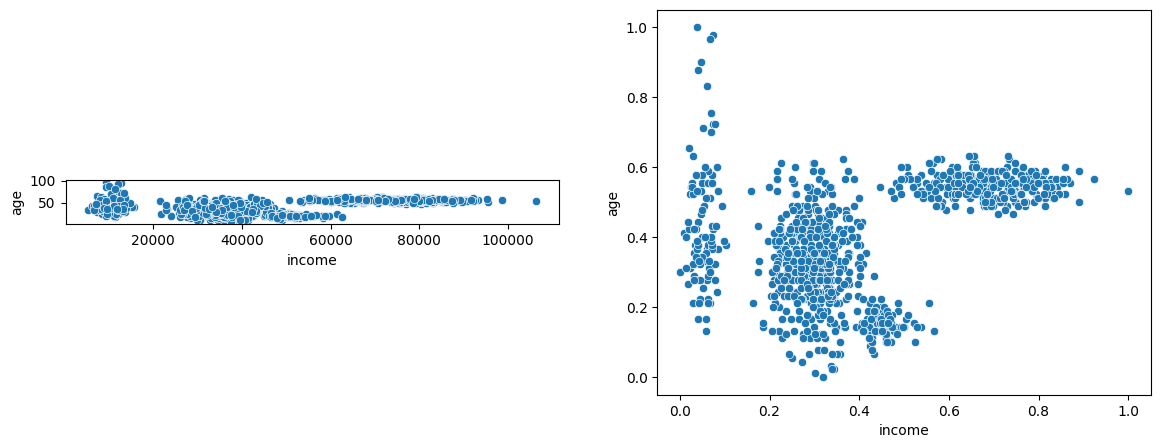

In [266]:
# Function Normalize
# Input = df, DataFrame we are interested in normalizing
# This is the Min/Max scaling method

def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_val = df[feature_name].max()
        min_val = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_val) / (max_val - min_val)

    return result
df_norm=normalize(df)

fig,ax=plt.subplots(1,2,figsize=(14,5))

sns.scatterplot(x='income', y='age',data=df_data, ax=ax[0])
sns.scatterplot(x='income', y='age',data=df_norm, ax=ax[1])
ax[0].set_aspect(100)

Los métodos mostrados arriba transformarán los datos de tal manera que la magnitud de todas las características sea aproximadamente similar. Sin embargo, puede haber un método de escalado diferente que permita que la agrupación de $k$-means funcione mejor. La mejor elección del método de escala depende de los datos específicos proporcionados.

## ¿Qué método de escalamiento deberíamos utilizar para nuestros datos?

## Ejercicio 4: (5 min)

Imagine una situación en la que, además de nuestro conjunto de datos original, hubiera algunas personas con ingresos altos que también presentaran reclamaciones de alto valor. ¿Qué podría salir mal con nuestro método de escalado anterior? ¿Cómo podrías lidiar con esto?

**Respuesta.** Estos puntos de datos se presentarían en la parte superior derecha de nuestro gráfico de reclamaciones versus ingresos y, por lo general, serían sucesos únicos (es decir, no frecuentes). Sin embargo, afectarían significativamente nuestro método de escalamiento mínimo-máximo (de manera muy similar a cómo los valores atípicos afectan significativamente a los modelos de regresión) y, por lo tanto, nuestro proceso de agrupación.

Una solución sería omitir estos puntos de datos, ya que no ocurren con demasiada frecuencia (una explicación plausible es que los datos pueden haberse ingresado accidentalmente con un 0 adicional, inflando así sus valores). Sin embargo, eliminar puntos de datos de la consideración es un gran paso y una opción que generalmente no queremos usar si podemos evitarlo. En general, nos gustaría utilizar procedimientos de escalamiento más sólidos que puedan abordar naturalmente estos valores atípicos. Una forma de escalar generalmente aceptada es dividir por la desviación estándar.


### Esto se explica mejor con un ejemplo:

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<Axes: xlabel='0', ylabel='1'>

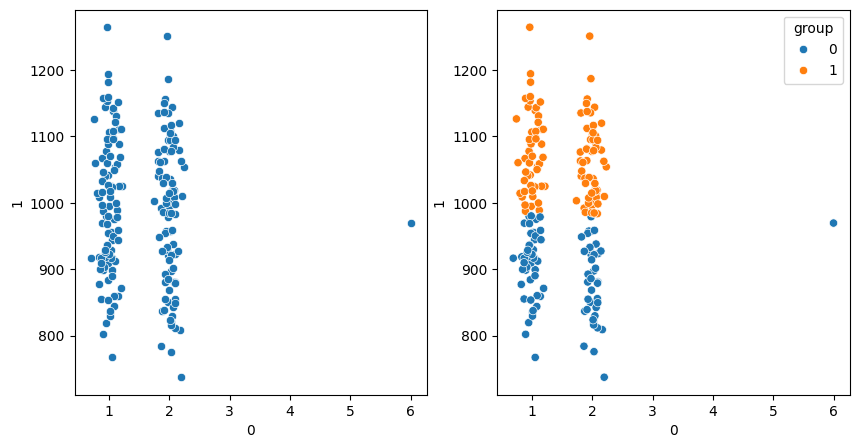

In [267]:
x1=np.random.normal(1,0.1, 100)
x2=np.random.normal(2,0.1, 100)
y1=np.random.normal(1000,100, 100)
y2=np.random.normal(1000,100, 100)
x=np.concatenate((x1,x2))
y=np.concatenate((y1,y2))
weird_data2=pd.DataFrame([x,y]).T

weird_data2.iloc[0,0]=6

k = 2
kmeans3 = KMeans(n_clusters=k, init='k-means++')
kmeans3.fit(weird_data2)

# Iterative procedure to learn labels
weird_data2['group'] = kmeans3.predict(weird_data2)

fig,ax=plt.subplots(1,2,figsize=(10,5))
sns.scatterplot(x=0, y=1, data=weird_data2,ax=ax[0])
sns.scatterplot(x=0, y=1, hue='group', data=weird_data2,ax=ax[1])
#ax[0].set_aspect(.1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<Axes: xlabel='x', ylabel='y'>

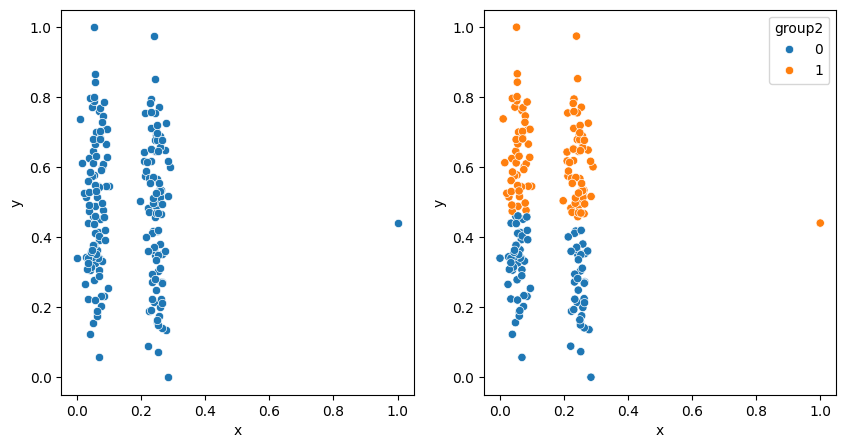

In [268]:
weird_data2['x']=(weird_data2[0]-weird_data2[0].min())/(weird_data2[0].max()-weird_data2[0].min())
weird_data2['y']=(weird_data2[1]-weird_data2[1].min())/(weird_data2[1].max()-weird_data2[1].min())
k = 2
kmeans4 = KMeans(n_clusters=k, init='k-means++')
kmeans4.fit(weird_data2[['x','y']])

# Iterative procedure to learn labels
weird_data2['group2'] = kmeans4.predict(weird_data2[['x','y']])

fig,ax=plt.subplots(1,2,figsize=(10,5))
sns.scatterplot(x='x', y='y', data=weird_data2,ax=ax[0])
sns.scatterplot(x='x', y='y', hue='group2', data=weird_data2,ax=ax[1])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<Axes: xlabel='x', ylabel='y'>

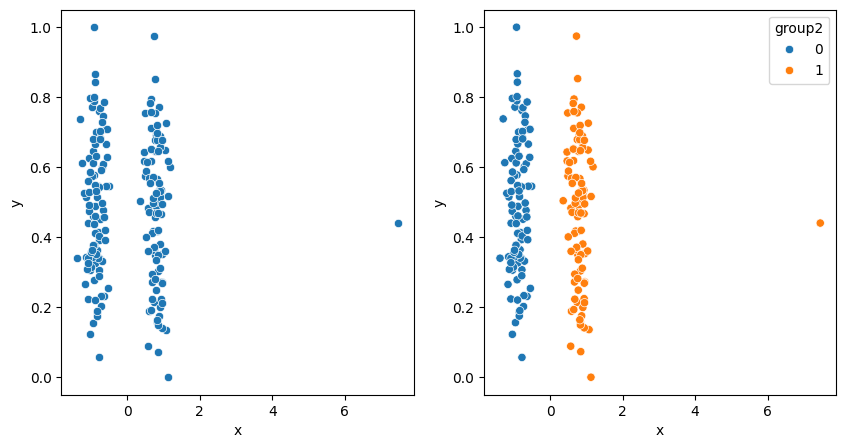

In [269]:
weird_data2['x']=(weird_data2[0]-weird_data2[0].mean())/weird_data2[0].std()
weird_data2['y']=(weird_data2[1]-weird_data2[1].min())/(weird_data2[1].max()-weird_data2[1].min())
k = 2
kmeans5 = KMeans(n_clusters=k, init='k-means++')
kmeans5.fit(weird_data2[['x','y']])

# Iterative procedure to learn labels
weird_data2['group2'] = kmeans5.predict(weird_data2[['x','y']])

fig,ax=plt.subplots(1,2,figsize=(10,5))
sns.scatterplot(x='x', y='y', data=weird_data2,ax=ax[0])
sns.scatterplot(x='x', y='y', hue='group2', data=weird_data2,ax=ax[1])

## Inicializando el cluster (25 min)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


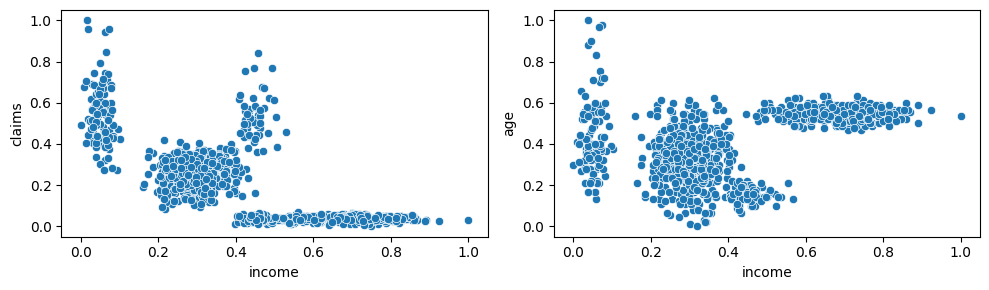

In [270]:
fig,ax=plt.subplots(1,2,figsize=(10,3))

sns.scatterplot(x='income', y='claims', data=df_norm,ax=ax[0])
sns.scatterplot(x='income', y='age',data=df_norm,ax=ax[1])
fig.tight_layout()

Con base en los datos normalizados, podemos hacer una suposición fundamentada de que tenemos 4 grupos:

1. Altos ingresos y bajos reclamos
2. Ingresos moderados y reclamaciones moderadas.
3. Ingresos moderados y altas demandas
4. Bajos ingresos y elevadas reclamaciones

Investiguemos más a fondo para determinar si esta es la mejor manera de agrupar los datos. Debemos empezar inicializando los primeros valores de los centroides:

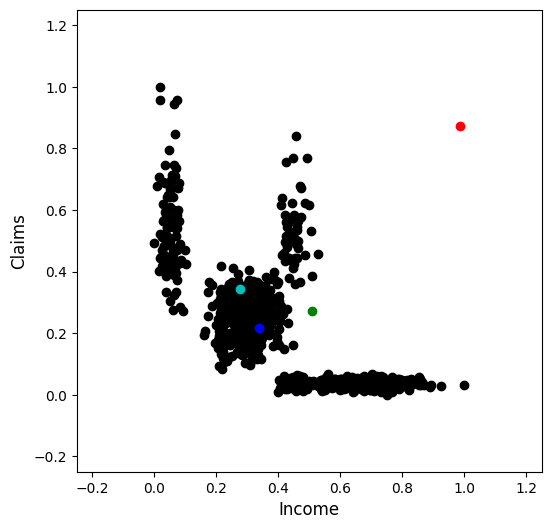

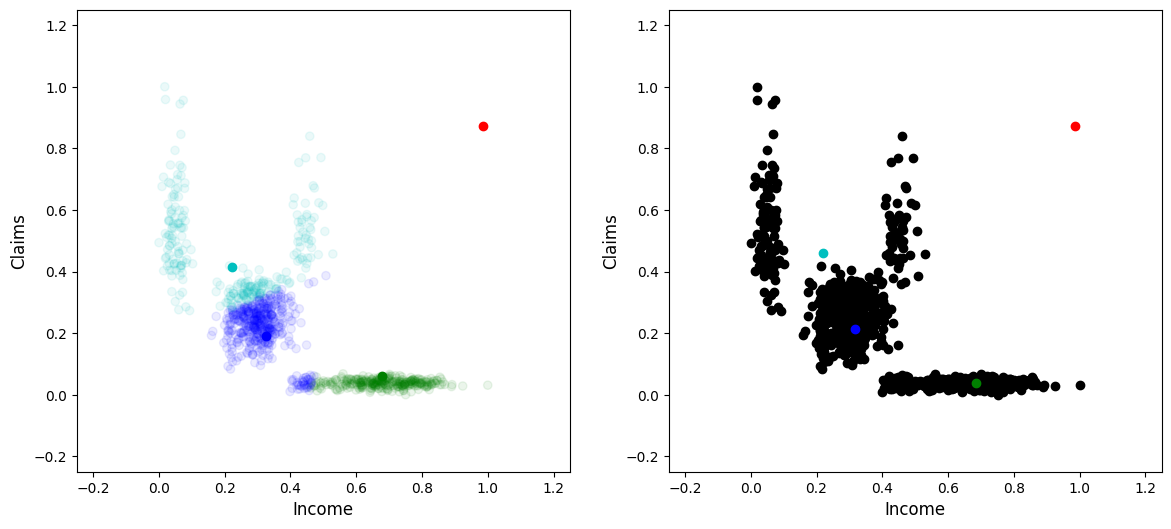

Aquí, hemos implementado una inicialización burda de los medios del clúster. En nuestro ejemplo anterior, nuestros grupos iniciales estaban bien posicionados y pudimos encontrar resultados razonablemente buenos después de solo dos iteraciones (al menos si solo tomamos en cuenta los "ingresos" y las "reclamaciones"). Sin embargo, el algoritmo puede ser bastante sensible a la inicialización (por ejemplo, intente cambiar la semilla aleatoria a 2020; el centroide rojo termina estando demasiado lejos para que el clasificador funcione como se esperaba). Afortunadamente para nosotros, el paquete `KMeans` de `sklearn` ya tiene la inicialización preestablecida para un método más sofisticado: `k-means++`.

La idea principal detrás del algoritmo de inicialización de `k-means++` es establecer los centroides iniciales como puntos aleatorios en nuestro conjunto de datos que se espera que estén bien distanciados entre sí. Más concretamente:

1. Seleccione un centroide $c_1$ al azar de nuestro conjunto de datos.
2. Calcule la distancia al cuadrado de cada otro punto en el conjunto de datos hasta $c_1$ y elija aleatoriamente el segundo centroide $c_2$ de acuerdo con las distancias observadas (cuanto mayor sea la distancia al cuadrado, mayor será la posibilidad de elegir el punto como centroide) .
3. Repetimos el mismo procedimiento con los centroides posteriores, pero en su lugar los elegimos aleatoriamente según la distancia al cuadrado al más cercano de los centroides ya seleccionados.

Se ha demostrado que este algoritmo es una [buena aproximación] (http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf) a la solución óptima de $k$-medias. Por tanto, es un muy buen comienzo para el algoritmo principal. Trabajaremos con esto de ahora en adelante.

### Implementación de $k$-means usando `sklearn` (5 min)

In [271]:
df_norm

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


income       age    claims
0    0.301264  0.400000  0.137252
1    0.185900  0.144444  0.355004
2    0.335762  0.344444  0.215563
3    0.276530  0.222222  0.352439
4    0.329915  0.533333  0.245925
..        ...       ...       ...
995  0.060143  0.833333  0.275895
996  0.034893  0.344444  0.745777
997  0.077830  0.322222  0.669978
998  0.041556  0.333333  0.545876
999  0.064738  0.333333  0.417988

[1000 rows x 3 columns]

In [272]:
from sklearn.cluster import KMeans

k = 4

kmeans = KMeans(n_clusters=k, init='k-means++')
kmeans.fit(df_norm)

# Iterative procedure to learn labels
labels = kmeans.predict(df_norm)
centroids = kmeans.cluster_centers_

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


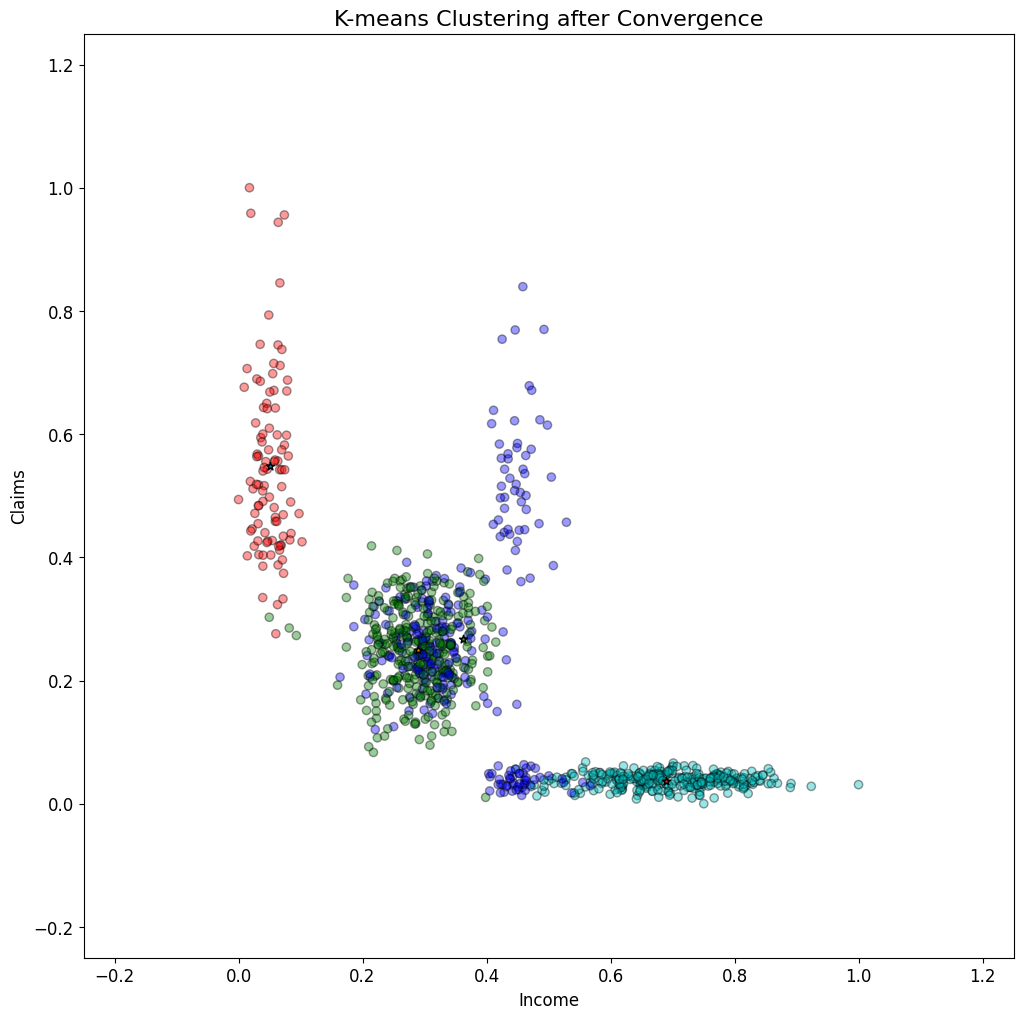

In [273]:
# Plot the data learned
plt.figure(figsize=(12, 12))

color_map = {1:'r', 2:'g', 3:'b' , 4:'c', 5:'y', 6:'w'}
colors = [color_map[x+1] for x in labels]

plt.scatter(df_norm['income'], df_norm['claims'], color=colors, alpha=0.4, edgecolor='k')

for idx, centroid in enumerate(centroids):
    plt.scatter(centroid[0],centroid[2], marker='*', edgecolor='k')

plt.xlim(-0.25, 1.25)
plt.xlabel('Income', fontsize=12)
plt.xticks(fontsize=12)

plt.ylim(-0.25, 1.25)
plt.ylabel('Claims', fontsize=12)
plt.yticks(fontsize=12)

plt.title('K-means Clustering after Convergence', fontsize=16)

plt.show()

## Seleccionando el valor optimo de $k$ (25 min)

Aunque el análisis visual sugiere que $k = 4$ es el valor óptimo, es una buena práctica verificarlo cuantitativamente en lugar de simplemente observarlo. Esto es especialmente importante cuando se agrupan datos que no se pueden visualizar fácilmente, algo que ocurre con frecuencia con datos multidimensionales complejos.

### Ejercicio 6: (5 min)

¿Cómo podría construir un método cuantitativo para determinar el $k$ óptimo?

**Respuesta.** Dado que el algoritmo $k$-means minimiza la suma de cuadrados dentro de cada grupo, esta es la función objetivo con la que debemos comparar todos los valores posibles de $k$. Podemos construir un gráfico lineal que muestre cómo esta suma de cuadrados cambia a medida que cambia $k$ y luego seleccionar el valor de $k$ con el valor más bajo.

Sin embargo, este método no funciona del todo; imagine el caso en el que tiene el mismo número de clústeres como puntos de datos. Entonces la suma de cuadrados es obviamente cero, ¡pero difícilmente se podría argumentar que tal agrupamiento sea una buena idea! Por lo tanto, es prudente agregar un término de penalización (similar a cómo la métrica AIC contiene un término de penalización) correspondiente al valor de $k$. Esto permitirá que nuestro gráfico toque fondo mucho antes de que $k$ sea demasiado grande, ya que el beneficio incremental de agregar solo un grupo más disminuye a medida que $k$ crece, mientras que la penalización incremental aumenta.

El método descrito en el Ejercicio 5 es una forma de **regularización**; sin embargo, todavía no estamos preparados para llegar allí. Por ahora, seremos un poco poco científicos al respecto, y en su lugar omitiremos el término de penalización y buscaremos el valor de $k$ en el gráfico lineal más allá del cual el cambio en la suma de cuadrados es efectivamente insignificante. Esto se llama **método del codo** o **elbow method**.

### Ejercicio 7: (10 min)

Implemente el esquema del método del codo que describimos anteriormente. ¿Nuestra suposición inicial de $k$ parece correcta?

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init

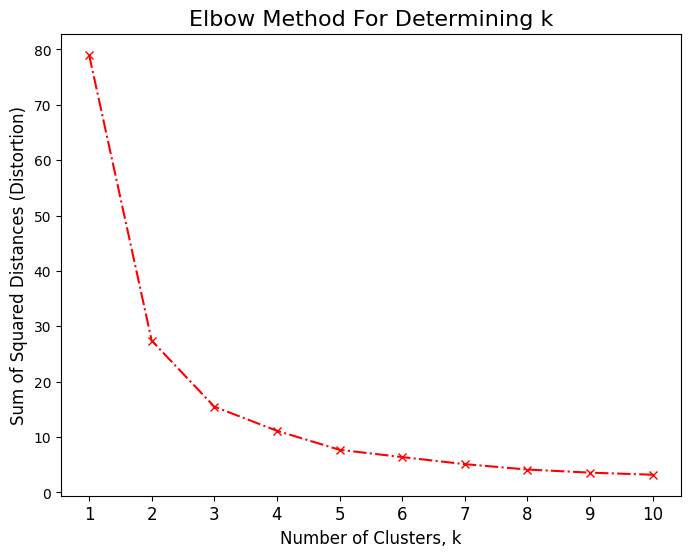

In [274]:
sum_sq_d = []
K = range(1,11)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_norm[['income', 'claims']])
    sum_sq_d.append(km.inertia_)

plt.figure(figsize=(8,6))

plt.plot(K, sum_sq_d, 'rx-.')

plt.xlabel('Number of Clusters, k', fontsize=12)
plt.xticks(range(1,11), fontsize=12)

plt.ylabel('Sum of Squared Distances (Distortion)', fontsize=12)
plt.xticks(fontsize=12)

plt.title('Elbow Method For Determining k', fontsize=16)

plt.show()

Del gráfico parecería que el valor de agregar más clústeres realmente comienza a disminuir alrededor de $k = 3$. $k = 4$ está muy cerca de eso, por lo que podemos decir que nuestra suposición inicial fue acertada (es bastante común que nuestra suposición visual y el resultado del método anterior sean ligeramente diferentes). Recuerde, este método funciona en múltiples dimensiones, por lo que, si bien la agrupación puede ser obvia en una dimensión, puede desaparecer cuando se combina con más variables.

# ¡Volvamos al problema original!
    
Muy bien, como prometimos, ahora tenemos una respuesta más informada sobre los tipos de grupos que tenemos en nuestros datos. Ahora, veamos si podemos detectar algún patrón para las reclamaciones fraudulentas dentro de cada grupo.

In [275]:
df_final=df_data.copy()
df_final['group']=labels
df_final.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


case_id    income  age sex  approval         fraud    claims  group
0    59982  35750.95   42   M  Approved  Under Review   9518.95      1
1    87249  24078.27   19   M    Denied            No  19354.23      2
2    50406  39241.52   37   M    Denied         Fraud  13056.04      1
3    59391  33248.31   26   M  Approved            No  19238.37      2
4    96622  38649.96   54   M  Approved            No  14427.42      1
5    56519  39001.26   43   F    Denied            No  14659.06      1
6    89783  36862.26   46   F  Approved            No  11390.09      1
7    99992  42827.23   47   F    Denied            No  17272.75      1
8    40096  34838.49   25   M  Approved            No  13164.17      2
9     1710  34714.20   27   F  Approved            No  11267.48      2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='income', ylabel='claims'>

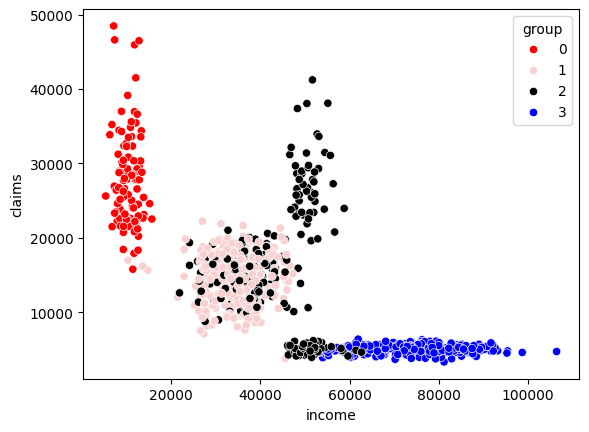

In [276]:
sns.scatterplot(x='income', y='claims', data=df_final,hue='group', palette=['red','#F9D0D0','black','blue'] )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


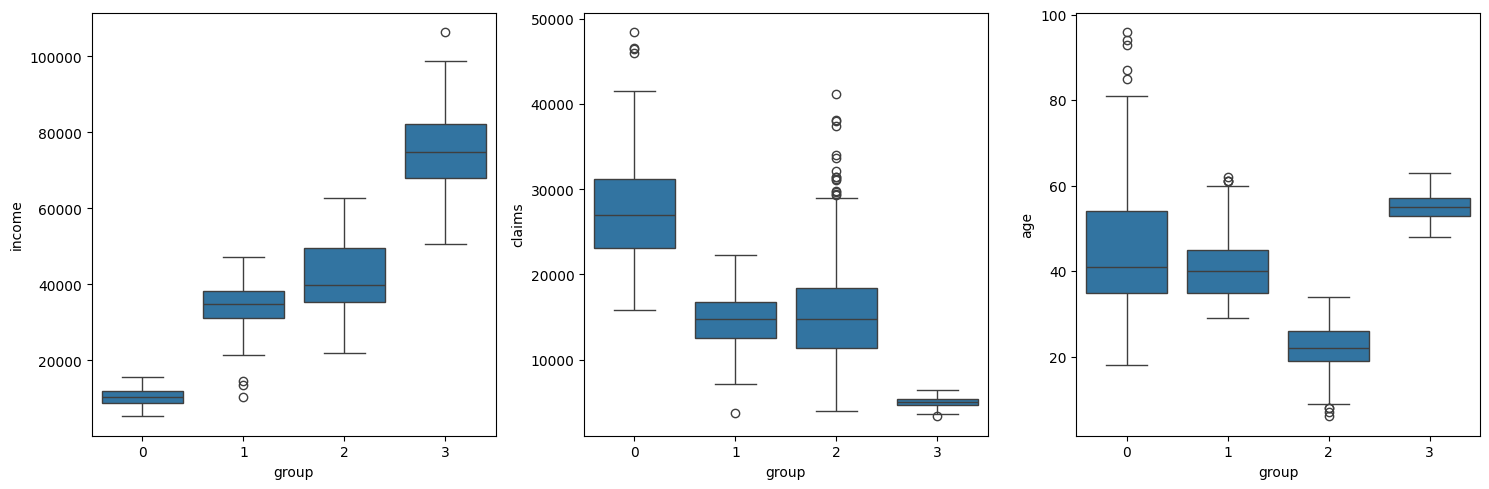

In [277]:
fig,ax=plt.subplots(1,3,figsize=(15,5))
sns.boxplot(x='group', y='income',data=df_final,ax=ax[0])
sns.boxplot(x='group', y='claims', data=df_final,ax=ax[1])
sns.boxplot(x='group', y='age',data=df_final,ax=ax[2])
fig.tight_layout()

>**Grupo 0**. Personas de casi todas las edades, con ingresos moderadamente bajos (20.000-50.000) y reclamaciones de entre 5.000 y 25.000 dólares. Puede no suponer mayor peligro en caso de fraude.
    
>**Grupo 1**. Personas de entre 50 y 60 años, con altos ingresos y bajos reclamos. Los fraudes aquí podrían no ser tan problemáticos.
    
>**Grupo 2**. Personas con bajos ingresos, menos de 20 mil y siniestros comparativamente altos. ¡En su mayoría adultos y podrían representar un riesgo si hay fraudes aquí!
    
>**Grupo 3**. Profesionales adultos jóvenes (ingresos moderados altos, alrededor de 50.000), pero con reclamaciones relativamente altas. Puede representar un peligro aquí también, aunque menos que el Grupo 2 en mi opinión.
    
Echemos un vistazo al mismo gráfico, esta vez teniendo en cuenta la columna de fraude:

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


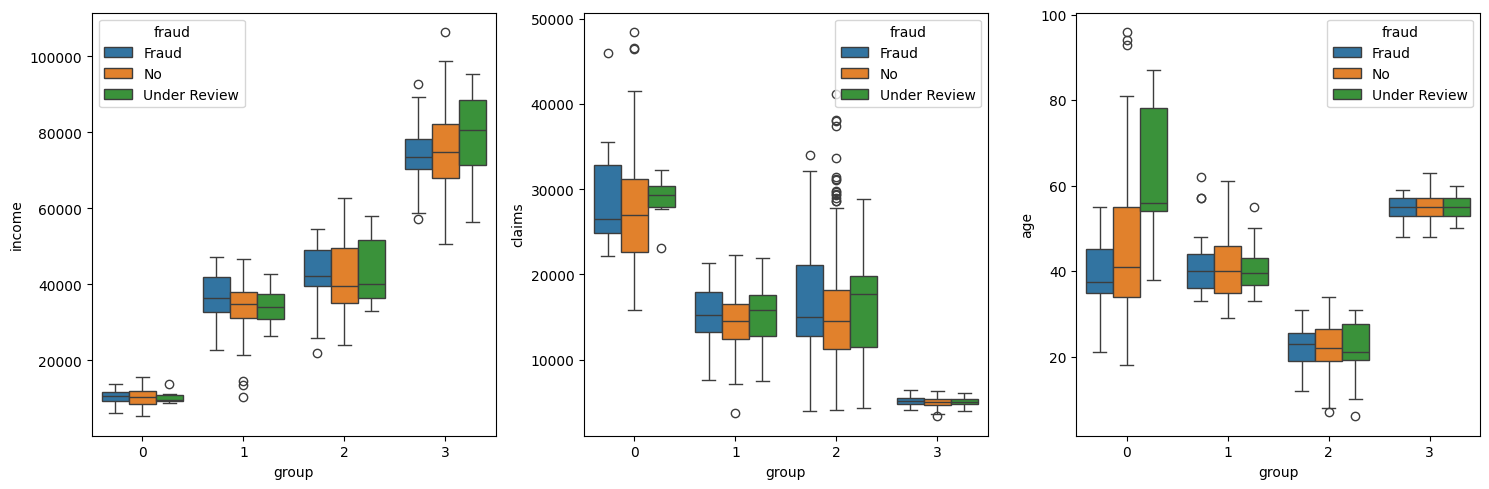

In [278]:
fig,ax=plt.subplots(1,3,figsize=(15,5))
sns.boxplot(x='group', y='income', hue='fraud',data=df_final,ax=ax[0])
sns.boxplot(x='group', y='claims', hue='fraud',data=df_final,ax=ax[1])
sns.boxplot(x='group', y='age', hue='fraud',data=df_final,ax=ax[2])
fig.tight_layout()

>Para el Grupo 0, vemos que ocurren varios fraudes con personas con ingresos más altos y reclamos más altos. Podemos intentar utilizar algunos de nuestros conocimientos sobre algoritmos de clasificación para validar esto.
    
> Para el Grupo 1, esto no está tan claro en mi opinión, al menos en estos gráficos. Parece que se están produciendo fraudes entre personas con ingresos de entre 60 y 80 mil.
    
>Para los otros dos grupos los fraudes son un poco más esporádicos y probablemente necesitaremos más datos para sacar conclusiones aquí, ¡especialmente porque estos dos tipos de reclamaciones pueden ser riesgosos!    

### Ejercicio 8 (5 min):

Dados los cuatro grupos de reclamos que identificamos con base en el cuadro de ingresos versus reclamos, y teniendo en cuenta la información en el cuadro de ingresos versus edad, haga una sugerencia sobre lo que el departamento debería hacer con cada grupo.

**Respuesta.** Tenemos cuatro grupos. El primero son aquellos con ingresos altos y reclamos bajos, que probablemente sean reclamos ordinarios presentados por familias adineradas. Es muy probable que no sean fraudulentos y que la empresa deba aceptarlos. El segundo son los ingresos moderados con valores de demanda moderados. Estos son bastante abundantes y podrían ser artículos cotidianos, como reclamos de automóviles. Lo más probable es que debamos aceptarlos. El tercero son los ingresos moderados y los elevados siniestros. Esto podría ser plausible si es algo que las personas de ingresos medios necesitan pero que no siempre pueden permitirse, como ciertas declaraciones de propiedades saludables. Entonces probablemente deberíamos investigar esto más a fondo. La última categoría son los ingresos bajos pero las reclamaciones muy elevadas. Claramente, estos no son asequibles y, con la excepción de algo como las declaraciones de propiedades saludables, bien podrían ser intentos de obtener dinero gratis. Lo más probable es que deberíamos rechazarlos.

### Ejercicio 9 (5 min):

Dado lo que ha aprendido sobre el algoritmo $k$-means, ¿cuáles son algunos de los posibles inconvenientes cuando se aplica a conjuntos de datos?

**Respuesta.** Existen algunas deficiencias potenciales (estos son ejemplos, obviamente hay otras respuestas posibles):

1. El algoritmo $k$-means da más peso a los grupos más grandes, ya que intenta minimizar la variación dentro del grupo, por lo que en los casos en que los grupos naturalmente no son del mismo tamaño, esto podría dar como resultado resultados sesgados.
2. No necesariamente converge de manera uniforme o rápida, por lo que elegir los puntos iniciales es sumamente importante. Este grado de dependencia no es necesariamente ideal.
3. Los valores atípicos pueden influir en gran medida en los datos y las medias de los grupos, a menos que se utilice una métrica alternativa.
4. El preprocesamiento de los datos y la normalización juegan un papel fundamental en los resultados modelos.

## Conclusiones (3 min)

En este caso, dividimos con éxito el conjunto de datos en 4 grupos separados y validamos nuestra intuición basada en la agrupación de $k$-medias. Aprendimos que hay muchas suposiciones incorporadas en la agrupación de $k$-medias (es decir, la elección de la métrica de distancia, la normalización y $k$) y que esto no se puede automatizar fácilmente, ya que estas elecciones dependen del conjunto de datos particular en el que se encuentran. mano. Una vez que se han identificado los grupos individuales, la compañía de seguros ahora puede determinar qué reclamaciones investigar más a fondo o considerar inmediatamente fraudulentas basándose en algunos criterios adicionales.

## Takeaways (5 min)

En este caso, introdujimos los conceptos de **aprendizaje no supervisado** y técnicas de **agrupación**. En particular, analizamos el algoritmo **$k$-means** y su funcionamiento interno. Hicimos esto por:

1. Visualizar un conjunto de datos para generar posibles clusters en nuestros datos
2. Presentamos el concepto de $k$-medios y cómo funciona el algoritmo.
3. Modificar los datos para ajustarlos a los errores del algoritmo.
4. Validar nuestra hipótesis inicial de los clusters en los datos implementando el algoritmo.
5. Probar otro nuevo modelo de clusterización representa ir a la página de modelos y seleccionar uno nuevo. #

La agrupación en clústeres es una poderosa herramienta de aprendizaje no supervisada para investigar datos no etiquetados, en particular para determinar patrones que no se conocían ni comprendían previamente. En el caso de grandes conjuntos de datos, se pueden identificar relaciones muy complejas entre grupos de puntos de datos individuales que no serían posibles a través del ojo humano.

Si bien esta es una buena técnica para datos de baja dimensión, $k$-means es susceptible a un rendimiento deficiente en dimensiones superiores, como muchos algoritmos de aprendizaje automático. En dimensiones superiores, primero se realizan técnicas más avanzadas, como **t-SNE**, para reducir el número de dimensiones antes de agruparlas. Finalmente, $k$-means es sólo uno de muchos algoritmos de agrupación. Los desarrollos modernos incluyen los algoritmos **DBSCAN** y **OPTICS**.

## Revisemos más conceptos ¿Qué tal si aplicamos PCA?

Ya que visualizamos todos los datos y que además los normalizamos, es necesario que implementacion la reduccion de dimensionalidad en el ejemplo.

Recordemos que :

- Si el conjunto de datos tiene muchas características, PCA puede reducir la dimensionalidad al identificar las características más importantes que explican la mayor parte de la variabilidad en los datos. Esto puede ser útil para visualizar los datos en un espacio de menor dimensión y para acelerar los algoritmos de clustering, como k-means, que pueden ser sensibles a la maldición de la dimensionalidad.


- Y si las características están altamente correlacionadas entre sí, PCA puede ayudar a reducir esta multicolinealidad al transformar las características originales en un conjunto de nuevas características no correlacionadas (los componentes principales), lo que puede mejorar la estabilidad y la interpretación de los resultados del clustering.

Entonces retomemos el ejemplo desde la normalización y apliquemos PCA a nuestro conjunto de datos, luego miremos cuanto porcentaje de los datos logramos explicar para identificar si despues de la reducción, tendremos buenos resultados:

In [279]:
df_norm

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


income       age    claims
0    0.301264  0.400000  0.137252
1    0.185900  0.144444  0.355004
2    0.335762  0.344444  0.215563
3    0.276530  0.222222  0.352439
4    0.329915  0.533333  0.245925
..        ...       ...       ...
995  0.060143  0.833333  0.275895
996  0.034893  0.344444  0.745777
997  0.077830  0.322222  0.669978
998  0.041556  0.333333  0.545876
999  0.064738  0.333333  0.417988

[1000 rows x 3 columns]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Porcentaje de Varianza Explicada por cada Componente Principal:
[0.71022703 0.19316728]
Porcentaje de Varianza Total Explicada: 90.34%


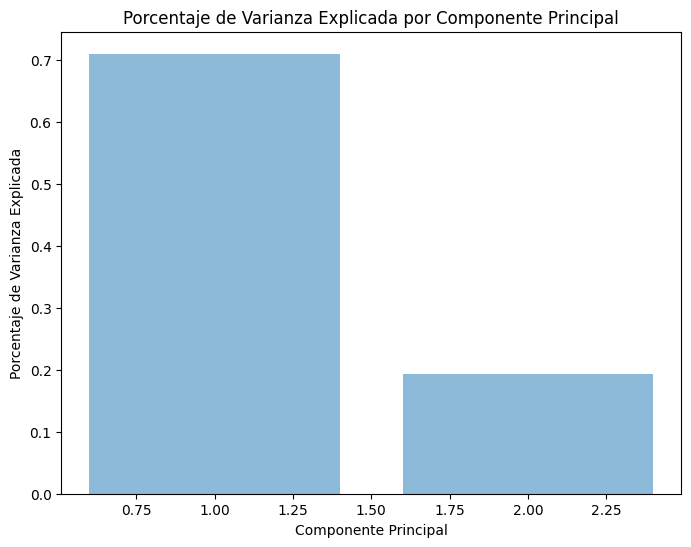

In [280]:
from sklearn.decomposition import PCA

# Preprocesamiento con PCA
pca = PCA(n_components=2)  # Por ejemplo, reducir a 2 componentes principales
df_pca_fit = pca.fit_transform(df_norm)

# Porcentaje de varianza explicada por cada componente principal
explained_variance_ratio = pca.explained_variance_ratio_

print("Porcentaje de Varianza Explicada por cada Componente Principal:")
print(explained_variance_ratio)

# Porcentaje de varianza total explicada
total_variance_explained = sum(explained_variance_ratio) * 100
print(f"Porcentaje de Varianza Total Explicada: {total_variance_explained:.2f}%")

# Visualización del porcentaje de varianza explicada
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, align='center')
plt.xlabel('Componente Principal')
plt.ylabel('Porcentaje de Varianza Explicada')
plt.title('Porcentaje de Varianza Explicada por Componente Principal')
plt.show()

### ¿Qué significa que el porcentaje varianza sea 90.34%?

Esto implica que las características originales están altamente correlacionadas entre sí y que la mayoría de la información contenida en estas características se captura de manera efectiva en un espacio de dimensionalidad reducida definido por las componentes principales.

En la práctica, un alto porcentaje de varianza explicada (por ejemplo, mayor al 90%) sugiere que la reducción de dimensionalidad mediante PCA ha sido efectiva para capturar la estructura subyacente de los datos con un número mucho menor de características, lo que puede simplificar el análisis y hacer que los datos sean más manejables y fáciles de interpretar.


## Inicializando cluster (PCA & K-means)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


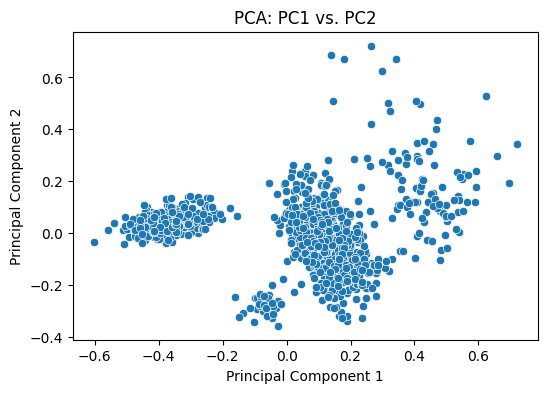

In [281]:
# Crea un DataFrame con los componentes principales
df_pca = pd.DataFrame(data=df_pca_fit, columns=['PC1', 'PC2'])

# Crear la figura y el subplot
plt.figure(figsize=(6, 4))

# Graficar PC1 vs. PC2
sns.scatterplot(x='PC1', y='PC2', data=df_pca)

# Configurar etiquetas y título
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: PC1 vs. PC2')

# Mostrar la gráfica
plt.show()

Este bloque de código proporciona una representación visual de la distribución de los datos en el espacio definido por los dos primeros componentes principales obtenidos mediante PCA. Esto puede ser útil para comprender la estructura de los datos en un espacio de dimensionalidad reducida y para identificar patrones o agrupaciones que puedan existir en los datos.


### Implementación de $k$-means con PCA

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


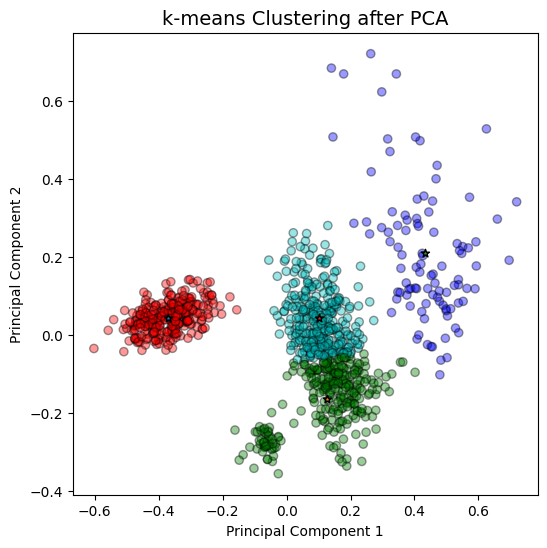

In [282]:
from sklearn.cluster import KMeans

# Aplicar k-means en los datos transformados
k = 4  # Número de clusters deseado
kmeans_pca = KMeans(n_clusters=k, init='k-means++')
kmeans_pca.fit(df_pca)

# Iterative procedure to learn labels
labels_pca = kmeans_pca.predict(df_pca)
centroids_pca = kmeans_pca.cluster_centers_

# Plot the data learned
plt.figure(figsize=(6, 6))

color_map = {1:'r', 2:'g', 3:'b', 4:'c', 5:'y', 6:'w'}
colors_pca = [color_map[x+1] for x in labels_pca]

plt.scatter(df_pca['PC1'], df_pca['PC2'], color=colors_pca, alpha=0.4, edgecolor='k')

for idx, centroid in enumerate(centroids_pca):
    plt.scatter(centroid[0],centroid[1], marker='*', edgecolor='k')

plt.xlabel('Principal Component 1', fontsize=10)
plt.ylabel('Principal Component 2', fontsize=10)
plt.title('k-means Clustering after PCA', fontsize=14)

plt.show()

Implementemos nuevamente el esquema del método del codo que describimos anteriormente. ¿Podemos seguir tomando la misma $k$ anterior? Adaptemos las lineas de codigo anteriores para llegar a una respuesta:

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init

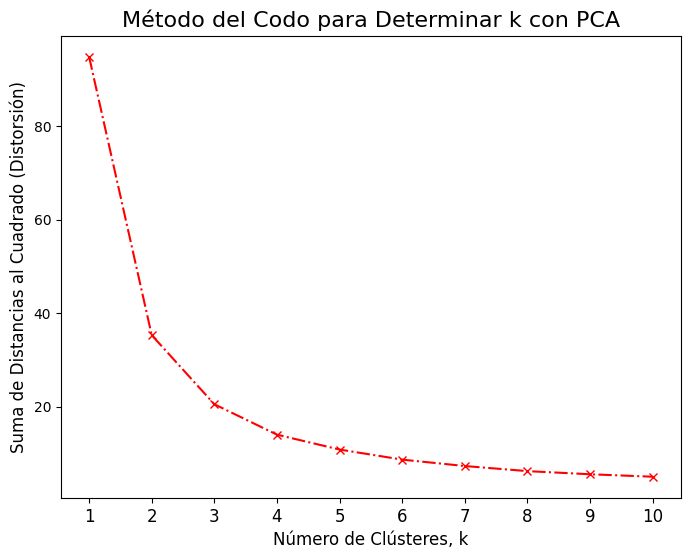

In [283]:

sum_sq_d_pca = []
K = range(1,11)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_pca)
    sum_sq_d_pca.append(km.inertia_)

plt.figure(figsize=(8,6))

plt.plot(K, sum_sq_d_pca, 'rx-.')

plt.xlabel('Número de Clústeres, k', fontsize=12)
plt.xticks(range(1,11), fontsize=12)

plt.ylabel('Suma de Distancias al Cuadrado (Distorsión)', fontsize=12)
plt.xticks(fontsize=12)

plt.title('Método del Codo para Determinar k con PCA', fontsize=16)

plt.show()



Excelente!. K = 4 parece ser tambien un buen valor para agrupar nuestros datos.

### Clustering Aglomerativo

Es importante destacar que además del método k-means, contamos con otra técnica conocida como clustering aglomerativo, que forma parte del enfoque de clustering jerárquico. En este contexto, podemos utilizar un dendrograma para visualizar la estructura jerárquica de los datos y así facilitar la elección del número óptimo de clusters, representado por el parámetro $k$.

El dendrograma nos proporciona una representación gráfica de cómo las muestras se agrupan y se dividen a medida que se forman los clusters, lo que nos permite comprender la estructura de los datos de manera más intuitiva y profunda.

Esta herramienta complementaria nos ayuda a explorar y comprender mejor la distribución de los datos, permitiéndonos tomar decisiones más informadas sobre la configuración óptima de clusters para nuestro análisis.

Veamos el código:


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


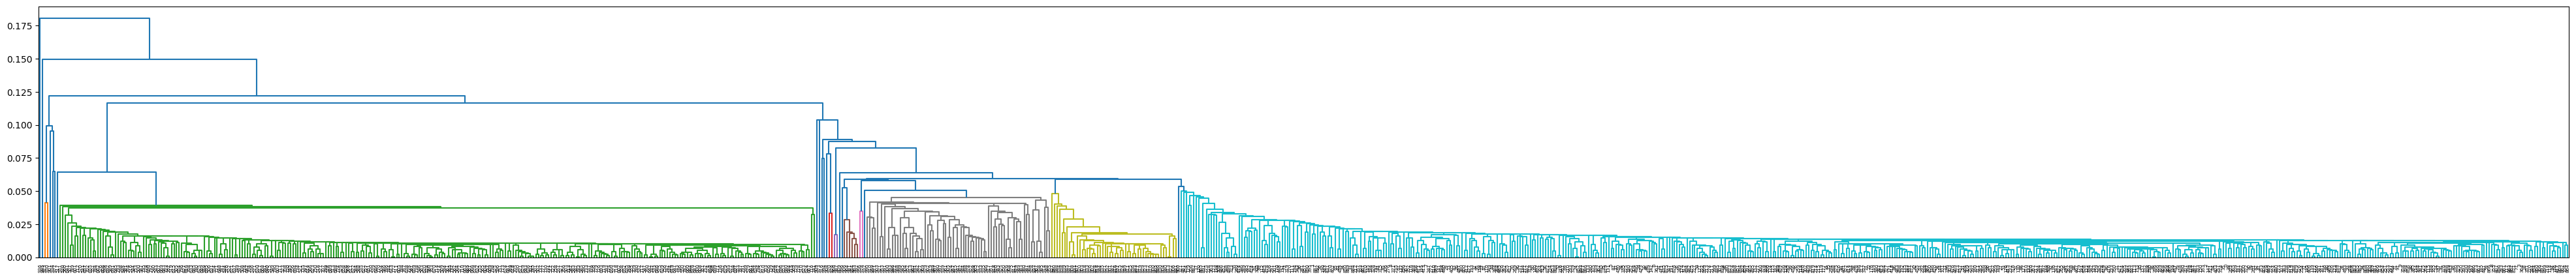

In [284]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

# Calcula la matriz de distancias entre tus datos de K-means
distance_mat = pdist(df_pca)

# Calcula el enlace jerárquico utilizando la matriz de distancias
Z = hierarchy.linkage(distance_mat, 'single')

# Visualiza el dendrograma
plt.figure(figsize=(50, 5))
dn = hierarchy.dendrogram(Z, color_threshold=0.05)
plt.show()

Entonces visualizamos el dendrograma con la función `dendrogram`, que toma el enlace jerárquico calculado y lo representa gráficamente. Aquí usamos el parámetro `color_threshold` para definir un umbral de color que puede ayudar a identificar los clusters. El dendrograma muestra cómo los puntos de datos se agrupan y se dividen a medida que se forman los clusters, lo que proporciona una comprensión visual de la estructura jerárquica de los datos y puede ayudar en la selección del número óptimo de clusters para el análisis de K-means.

Cabe resaltar que `color_threshold` es un valor que se adapta manualmente a las necesidades del problema y que al momento de graficar exageramos un poco con el valor del eje x para visualizar de mejor manera las lineas que se sobrelapaban al inicio de dicho eje.

La cantidad de los datos nos muestran que se puede complicar un poco la elección de un valor para $k$ con este algoritmo, sin embargo vemos como relacionan los resultados del método del codo y el dendograma. Con el primero "método del codo" elegimos un valor para $k$ = 4, y del segundo "el dendrograma" podemos ver que la partición que hicimos nos orienta a un valor para $k$=5. Al no estar muy alejados dichos valores, seguiremos trabando con $k$ = 4.

# ¡Volvamos al problema original (PCA & K-means)!

Usemos las nuevas etiquetas para generar nuestra gráfica con los datos originales y lograr ver las nuevas agrupaciones que se han generado:


In [285]:
df_final_pca = df_data.copy()
df_final_pca['group'] = labels_pca
df_final_pca.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


case_id    income  age sex  approval         fraud    claims  group
0    59982  35750.95   42   M  Approved  Under Review   9518.95      3
1    87249  24078.27   19   M    Denied            No  19354.23      1
2    50406  39241.52   37   M    Denied         Fraud  13056.04      3
3    59391  33248.31   26   M  Approved            No  19238.37      1
4    96622  38649.96   54   M  Approved            No  14427.42      3
5    56519  39001.26   43   F    Denied            No  14659.06      3
6    89783  36862.26   46   F  Approved            No  11390.09      3
7    99992  42827.23   47   F    Denied            No  17272.75      3
8    40096  34838.49   25   M  Approved            No  13164.17      1
9     1710  34714.20   27   F  Approved            No  11267.48      1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='income', ylabel='claims'>

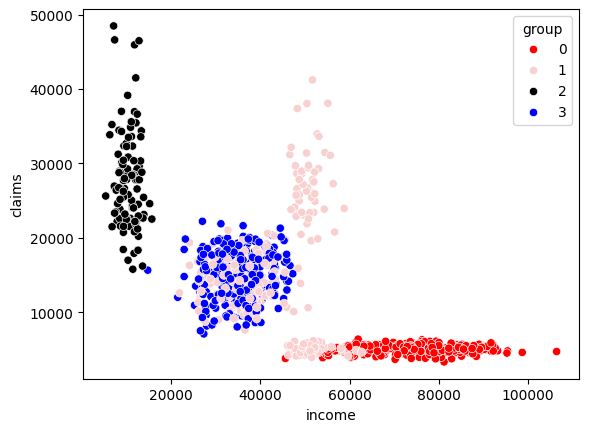

In [286]:
sns.scatterplot(x='income', y='claims', data=df_final_pca,hue='group', palette=['red','#F9D0D0','black','blue'] )

A primera vista, la gráfica generada con PCA & K-means parece muy similar a la anterior, donde solo se utilizó el algoritmo de k-means. Sin embargo, es importante analizar si existen diferencias significativas entre ambas representaciones. Aunque visualmente parecidas, podemos profundizar en el análisis para determinar si son completamente idénticas en términos de estructura y distribución de los clusters.

### Veamos la primera comparación de algoritmos

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


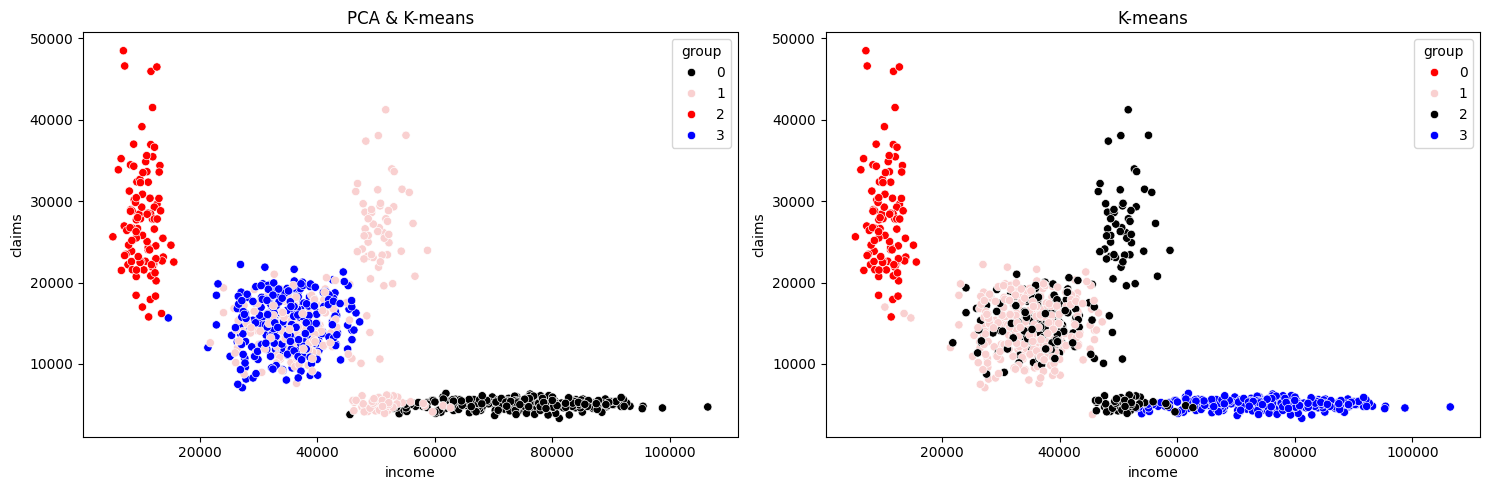

In [287]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Gráfica PCA & K-means
sns.scatterplot(x='income', y='claims', data=df_final_pca, hue='group', palette=['black','#F9D0D0','red','blue'], ax=ax[0])
ax[0].set_title('PCA & K-means')

# Gráfica K-means
sns.scatterplot(x='income', y='claims', data=df_final, hue='group', palette=['red','#F9D0D0','black','blue'], ax=ax[1])
ax[1].set_title('K-means')

fig.tight_layout()
plt.show()

Si observamos detenidamente, aunque ambas gráficas son visualmente similares, podemos notar que la representación generada mediante PCA & K-means muestra una agrupación más clara y definida en comparación con el dendrograma del cluster aglomerativo. Esto sugiere una mayor cohesión entre los clusters identificados con el método de PCA y K-means, lo que puede indicar una estructura más robusta y discernible en los datos. Esta mejor agrupación en el resultado visual final puede ser crucial para una interpretación precisa de los patrones y relaciones presentes en los datos.


### Gráficas finales del problema para analizar (PCA & K-means)

Estos son los resultados más recientes en nuestra búsqueda para resolver el problema planteado. Anteriormente, hemos detallado los aspectos clave que nos ayudan a comprender rápidamente el significado de estos resultados. Sin embargo, no nos detendremos aquí, ya que continuaremos explorando otros algoritmos. Entonces veremos las gráficas asociadas con estos resultados y seguimos buscando una comprensión más profunda y exhaustiva de los datos mediante la aplicación de diferentes enfoques y técnicas.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


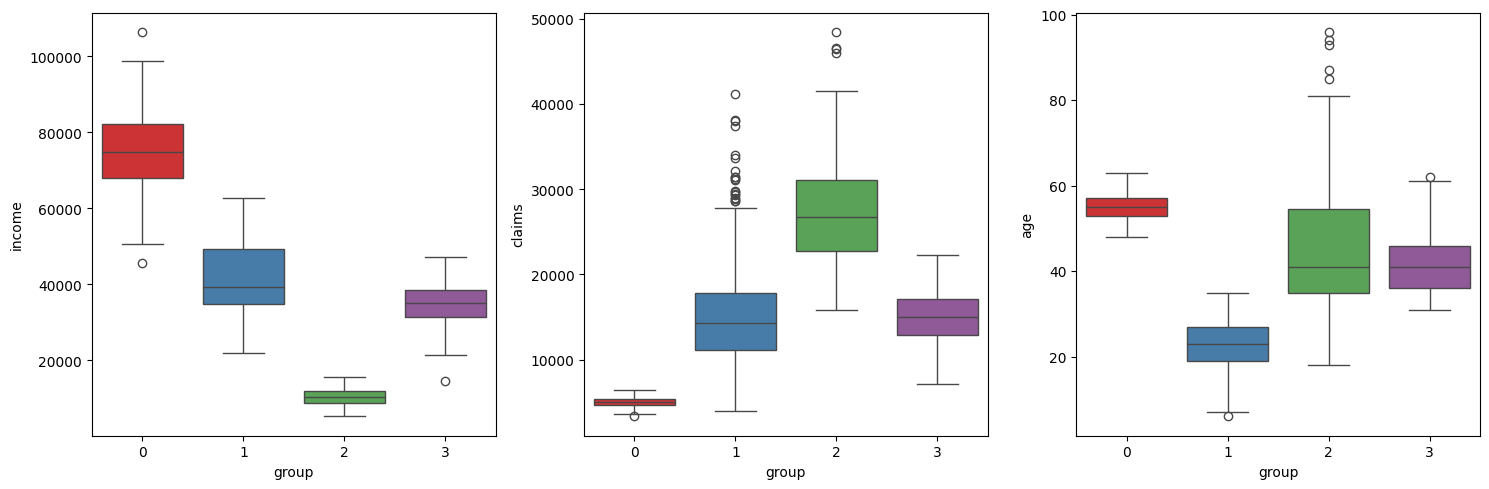

In [288]:
# Crear los boxplots con la asignación de hue y legend=False
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(x='group', y='income', data=df_final_pca, ax=ax[0], hue='group', palette='Set1', legend=False)
sns.boxplot(x='group', y='claims', data=df_final_pca, ax=ax[1], hue='group', palette='Set1', legend=False)
sns.boxplot(x='group', y='age', data=df_final_pca, ax=ax[2], hue='group', palette='Set1', legend=False)
fig.tight_layout()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


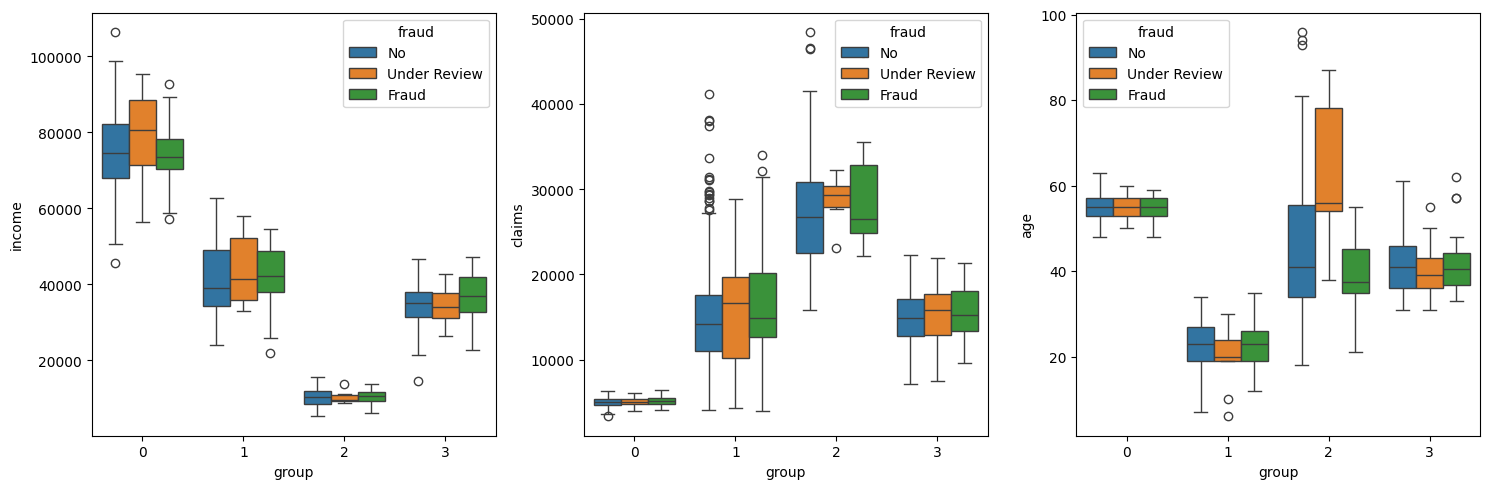

In [289]:
fig,ax=plt.subplots(1,3,figsize=(15,5))
sns.boxplot(x='group', y='income', hue='fraud',data=df_final_pca,ax=ax[0])
sns.boxplot(x='group', y='claims', hue='fraud',data=df_final_pca,ax=ax[1])
sns.boxplot(x='group', y='age', hue='fraud',data=df_final_pca,ax=ax[2])
fig.tight_layout()

## ¿Qué resultados tendremos con DBScan?

Recordemos que debemos tener en cuenta dos vairables para usar DBScan:

#### $Eps$ (epsilon):

Eps determina la distancia máxima entre dos muestras para que se consideren en el mismo vecindario. Es decir, establece el radio de la vecindad alrededor de cada punto.
- Puedes visualizar tus datos y observar la distribución de las distancias entre los puntos para obtener una idea de qué valores de eps pueden ser apropiados.


#### $Min_samples$:
Es el número mínimo de muestras en un vecindario para que un punto sea considerado como núcleo (core point).
- Un valor más alto de min_samples resultará en menos puntos considerados como núcleo, lo que podría llevar a la formación de clusters más grandes.
- Un valor demasiado bajo puede hacer que muchos puntos sean considerados como ruido.

> La elección de los valores de eps y min_samples es un proceso iterativo que implica experimentación, visualización y evaluación de los resultados para encontrar la configuración óptima que se ajuste mejor a tu conjunto de datos y objetivos de clustering.

In [290]:
eps = 0.8  # Definir el radio de la vecindad
min_samples = 5  # Definir el número mínimo de muestras en la vecindad

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Número de clusters encontrados por DBSCAN: 1
Porcentaje de puntos considerados como ruido por DBSCAN: 0.0 %


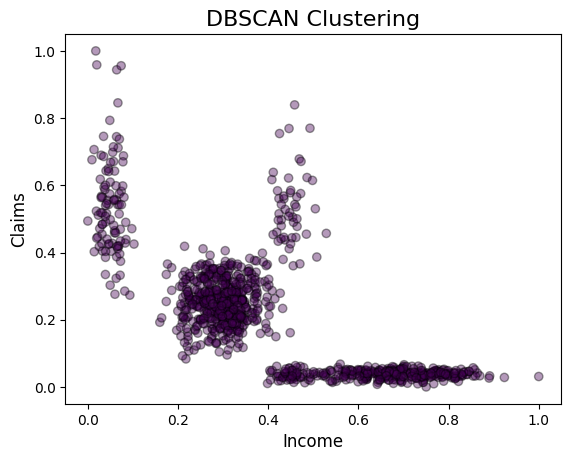

In [291]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels_dbscan = dbscan.fit_predict(df_norm)


# Número de clusters encontrados por DBSCAN
n_clusters_dbscan = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
print("Número de clusters encontrados por DBSCAN:", n_clusters_dbscan)

# Porcentaje de puntos considerados como ruido por DBSCAN
percent_noise = list(labels_dbscan).count(-1) / len(labels_dbscan) * 100
print("Porcentaje de puntos considerados como ruido por DBSCAN:", percent_noise, "%")

plt.scatter(df_norm['income'], df_norm['claims'], c=labels_dbscan, cmap='viridis', alpha=0.4, edgecolor='k')
plt.xlabel('Income', fontsize=12)
plt.ylabel('Claims', fontsize=12)
plt.title('DBSCAN Clustering', fontsize=16)

plt.show()



Nuestro intento inicial de encontrar grupos con DBSCAN utilizando valores aleatorios para `eps` y `min_samples` no produjo resultados satisfactorios. Esto indica que la selección de estos parámetros fue subóptima.

Dado que `eps` está estrechamente relacionado con las distancias entre puntos, es crucial elegir un valor que refleje adecuadamente la estructura de los datos. Una forma de abordar este problema es visualizar las distancias entre puntos en nuestros datos. Esto nos dará una idea de cuán dispersos están los puntos y nos ayudará a seleccionar un valor adecuado para `eps`.

A continuación, presentamos un código que nos permite visualizar las distancias entre puntos y tomar decisiones más informadas sobre la configuración de `eps` en DBSCAN

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


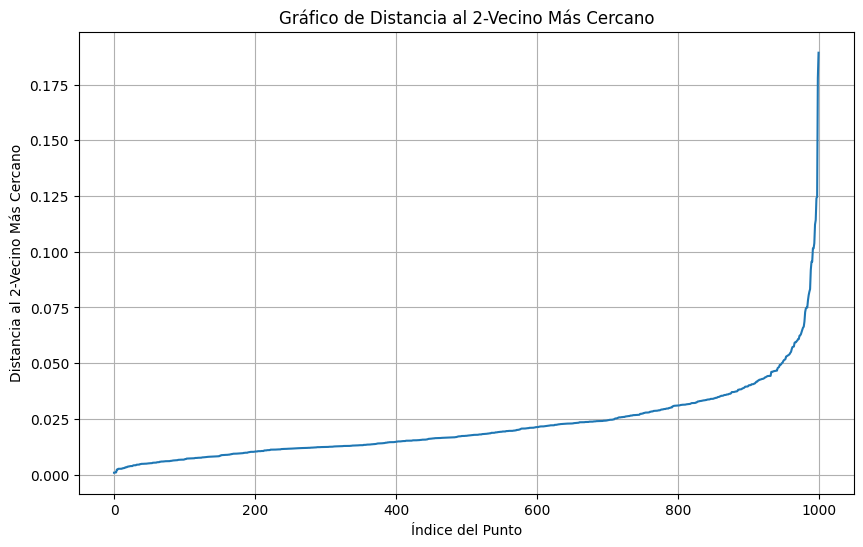

In [292]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# Calcular la distancia de los k-vecinos más cercanos para cada punto
# Aquí, establecemos k = 2 para calcular la distancia al segundo vecino más cercano
k = 2
nbrs = NearestNeighbors(n_neighbors=k).fit(df_norm)
distances, indices = nbrs.kneighbors(df_norm)

# Ordenar las distancias y graficarlas
distances = np.sort(distances, axis=0)
distances = distances[:,1]  # Tomar la distancia al segundo vecino más cercano

# Gráfico de distancia vs. número de puntos
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Índice del Punto')
plt.ylabel(f'Distancia al {k}-Vecino Más Cercano')
plt.title(f'Gráfico de Distancia al {k}-Vecino Más Cercano')
plt.grid(True)
plt.show()

Dado que nuestros datos están normalizados, al observar la gráfica de distancias entre puntos, notamos que teníamos un valor de `eps` relativamente grande en la escala normalizada. Como resultado, decidimos ajustar `eps` a 0.1 para tener en cuenta esta diferencia de escala y mejorar la efectividad del algoritmo DBSCAN en la identificación de grupos significativos en nuestros datos.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Número de clusters encontrados por DBSCAN: 4
Porcentaje de puntos considerados como ruido por DBSCAN: 2.7 %


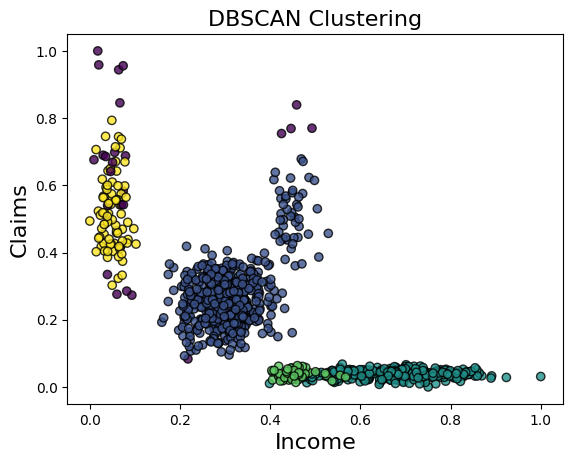

In [293]:
from sklearn.cluster import DBSCAN


eps = 0.09  # Definir el radio de la vecindad
min_samples = 9 # Definir el número mínimo de muestras en la vecindad
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels_dbscan = dbscan.fit_predict(df_norm)


# Número de clusters encontrados por DBSCAN
n_clusters_dbscan = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
print("Número de clusters encontrados por DBSCAN:", n_clusters_dbscan)

# Porcentaje de puntos considerados como ruido por DBSCAN
percent_noise = list(labels_dbscan).count(-1) / len(labels_dbscan) * 100
print("Porcentaje de puntos considerados como ruido por DBSCAN:", percent_noise, "%")

plt.scatter(df_norm['income'], df_norm['claims'], c=labels_dbscan, cmap='viridis', alpha=0.8, edgecolor='k')
plt.xlabel('Income', fontsize=16)
plt.ylabel('Claims', fontsize=16)
plt.title('DBSCAN Clustering', fontsize=16)

plt.show()


En este caso podemos asumir que presenciamos los 3 colores de los clusters y un 4to color que referencia el ruido.

"La selección de `min_samples` fue un proceso más iterativo, buscando una gráfica lo más organizada posible y minimizando el ruido. Finalmente, optamos por establecer su valor en 3.

**¿Qué sucede con el ruido?** Este se manifiesta como datos adicionales que carecen de relación con el resto, lo que resulta en una pérdida de información.

- `min_samples` = 1: Se observa poco ruido pero los datos están desordenados.
- `min_samples` = 5: Existe un ruido moderado, pero los datos son fácilmente identificables.
- `min_samples` < 10: A medida que aumentamos este valor, el ruido se incrementa, lo que resulta en una gráfica menos legible.

Por lo tanto, al final identificamos 3 grupos principales.

**¿Y por qué observamos 4 colores?** En este caso, podemos asumir que vemos los 3 colores que representan los clusters, junto con un cuarto color que indica la presencia de ruido.

# ¡Volvamos al problema original (con DBScan)!



In [294]:
df_final_dbscan=df_data.copy()
df_final_dbscan['group']=labels_dbscan
df_final_dbscan.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


case_id    income  age sex  approval         fraud    claims  group
0    59982  35750.95   42   M  Approved  Under Review   9518.95      0
1    87249  24078.27   19   M    Denied            No  19354.23      0
2    50406  39241.52   37   M    Denied         Fraud  13056.04      0
3    59391  33248.31   26   M  Approved            No  19238.37      0
4    96622  38649.96   54   M  Approved            No  14427.42      0
5    56519  39001.26   43   F    Denied            No  14659.06      0
6    89783  36862.26   46   F  Approved            No  11390.09      0
7    99992  42827.23   47   F    Denied            No  17272.75      0
8    40096  34838.49   25   M  Approved            No  13164.17      0
9     1710  34714.20   27   F  Approved            No  11267.48      0

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-295-aef234147f9d>:1: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x='income', y='claims', data=df_final_dbscan,hue='group', palette=['red','#F9D0D0','black','blue'] )


<Axes: xlabel='income', ylabel='claims'>

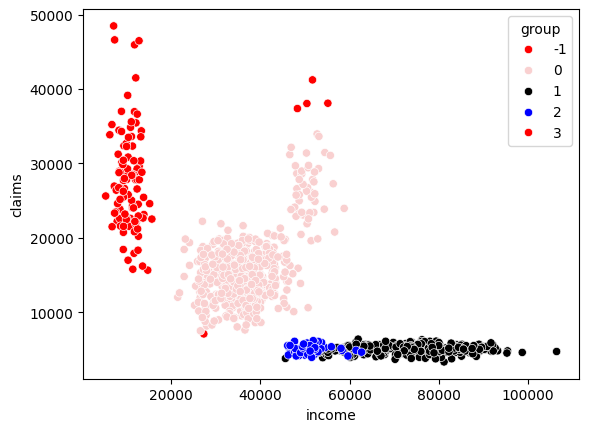

In [295]:
sns.scatterplot(x='income', y='claims', data=df_final_dbscan,hue='group', palette=['red','#F9D0D0','black','blue'] )

En relación a lo asumido anteriormente, las clases están numeradas del 0 al 2, con una clase adicional etiquetada como -1 que representa el ruido en nuestras agrupaciones.

### Gráficas finales del problema para analizar (DBScan)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


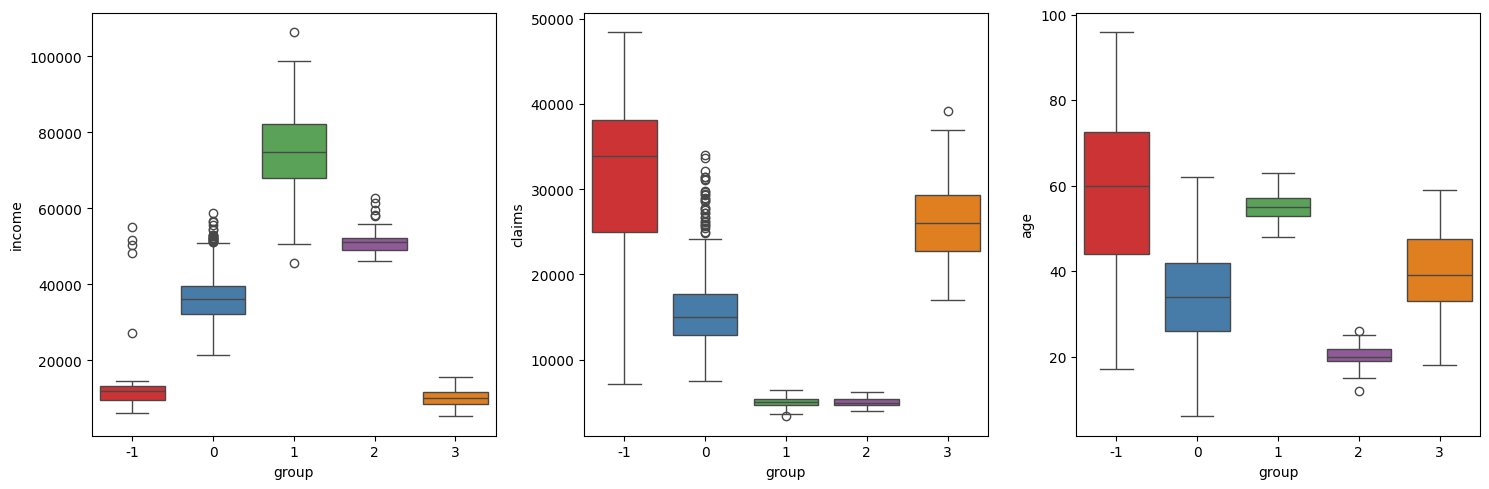

In [296]:
# Crear los boxplots con la asignación de hue y legend=False
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(x='group', y='income', data=df_final_dbscan, ax=ax[0], hue='group', palette='Set1', legend=False)
sns.boxplot(x='group', y='claims', data=df_final_dbscan, ax=ax[1], hue='group', palette='Set1', legend=False)
sns.boxplot(x='group', y='age', data=df_final_dbscan, ax=ax[2], hue='group', palette='Set1', legend=False)
fig.tight_layout()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


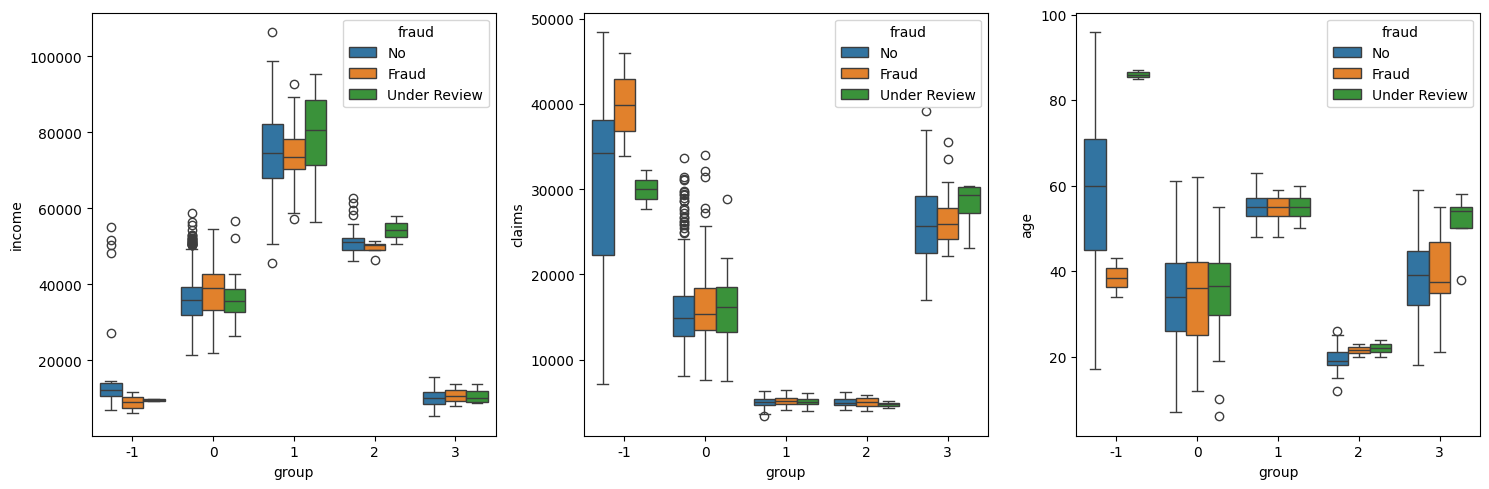

In [297]:
fig,ax=plt.subplots(1,3,figsize=(15,5))
sns.boxplot(x='group', y='income', hue='fraud',data=df_final_dbscan,ax=ax[0])
sns.boxplot(x='group', y='claims', hue='fraud',data=df_final_dbscan,ax=ax[1])
sns.boxplot(x='group', y='age', hue='fraud',data=df_final_dbscan,ax=ax[2])
fig.tight_layout()

## Miremos como van nuestras comparaciones de modelos - Segunda comparación

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-298-2785d80da019>:11: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x='income', y='claims', data=df_final_dbscan,hue='group', palette=['red','black','#F9D0D0','blue'], ax=ax[2] )


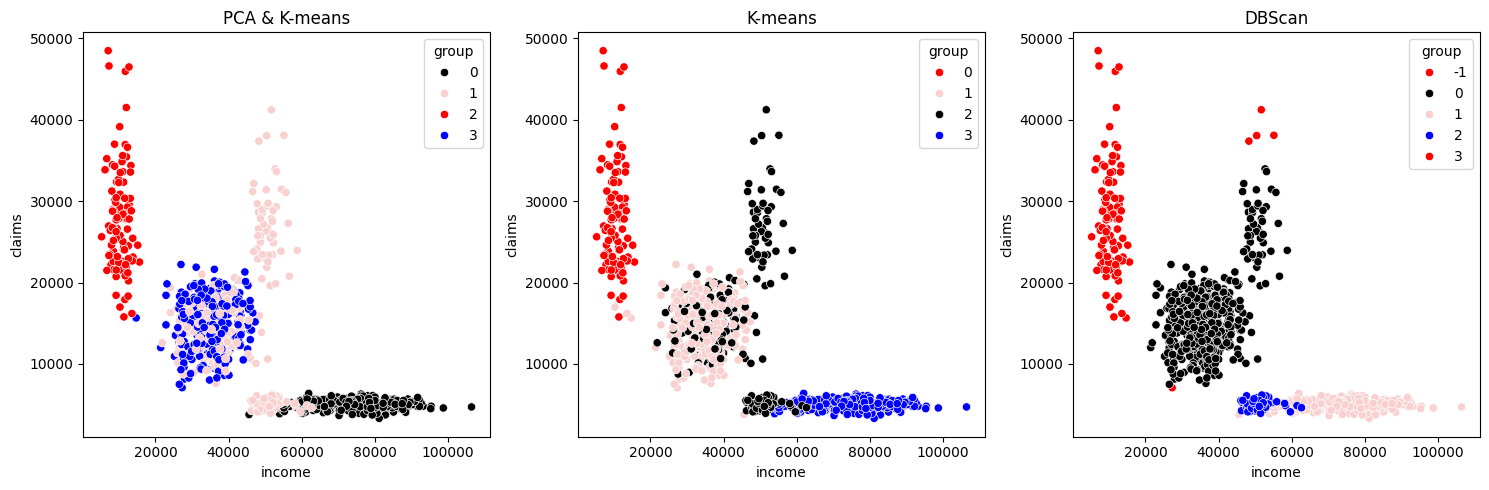

In [298]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Gráfica PCA & K-means
sns.scatterplot(x='income', y='claims', data=df_final_pca, hue='group', palette=['black','#F9D0D0','red','blue'], ax=ax[0])
ax[0].set_title('PCA & K-means')

# Gráfica K-means
sns.scatterplot(x='income', y='claims', data=df_final, hue='group', palette=['red','#F9D0D0','black','blue'], ax=ax[1])
ax[1].set_title('K-means')

sns.scatterplot(x='income', y='claims', data=df_final_dbscan,hue='group', palette=['red','black','#F9D0D0','blue'], ax=ax[2] )
ax[2].set_title('DBScan')

fig.tight_layout()
plt.show()

Es muy probable que si hubiéramos elegido previamente $k$=3 en los casos anteriores, habríamos obtenido gráficos bastante similares. Sin embargo, es importante destacar que este algoritmo, al utilizar DBSCAN, determina automáticamente su valor de k, lo cual depende de los parámetros `eps` y `min_samples` que trabajamos en los bloques anteriores. Esto brinda una mayor flexibilidad y adaptabilidad a la estructura de los datos, permitiendo que el algoritmo se ajuste de manera más precisa a la distribución y densidad de los puntos en el espacio de características.

## Incorporando PCA a DBScan: Explorando la Reducción de Dimensionalidad por segunda vez

Después de normalizar nuestros datos, aplicamos PCA para reducir su dimensionalidad. Pasamos así de la variable df_norm, que contiene los datos normalizados, a df_pca, que almacena los datos normalizados y reducidos dimensionalmente.

Ahora, retomaremos este punto y haremos algunos ajustes al enfoque anterior, en el que solo utilizamos DBScan.

En esta ocasión, no volveremos a seleccionar los valores de eps y min_samples, ya que los elegimos previamente. Veremos cómo funciona DBScan con los mismos valores elegidos:

In [299]:
df_pca

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PC1       PC2
0    0.026293  0.013416
1    0.321464 -0.145821
2    0.063510 -0.025500
3    0.226513 -0.092191
4    0.023544  0.161611
..        ...       ...
995  0.145151  0.508435
996  0.593696  0.176987
997  0.525226  0.127126
998  0.477597  0.112500
999  0.386793  0.073984

[1000 rows x 2 columns]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Número de clusters encontrados por DBSCAN: 2
Porcentaje de puntos considerados como ruido por DBSCAN: 1.0 %


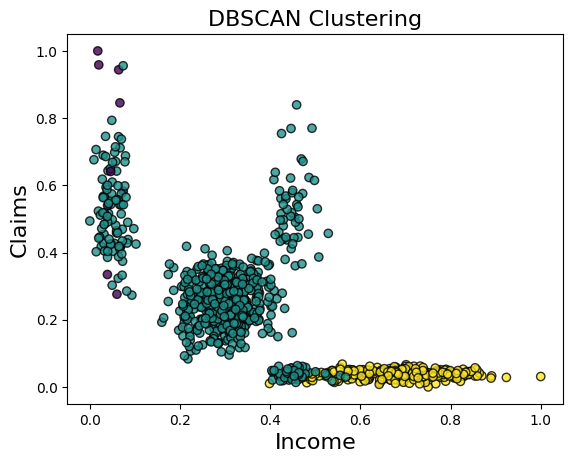

In [300]:
from sklearn.cluster import DBSCAN


eps = 0.1  # Definir el radio de la vecindad
min_samples = 4 # Definir el número mínimo de muestras en la vecindad
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels_dbscan_pca = dbscan.fit_predict(df_pca)


# Número de clusters encontrados por DBSCAN
n_clusters_dbscan = len(set(labels_dbscan_pca)) - (1 if -1 in labels_dbscan_pca else 0)
print("Número de clusters encontrados por DBSCAN:", n_clusters_dbscan)

# Porcentaje de puntos considerados como ruido por DBSCAN
percent_noise = list(labels_dbscan_pca).count(-1) / len(labels_dbscan_pca) * 100
print("Porcentaje de puntos considerados como ruido por DBSCAN:", percent_noise, "%")

plt.scatter(df_norm['income'], df_norm['claims'], c=labels_dbscan_pca, cmap='viridis', alpha=0.8, edgecolor='k')
plt.xlabel('Income', fontsize=16)
plt.ylabel('Claims', fontsize=16)
plt.title('DBSCAN Clustering', fontsize=16)

plt.show()

Nuestro análisis con DBScan nos arrojó 3 agrupaciones y un porcentaje de ruido de 0.4%. Aunque este valor de ruido es bajo, al observar el resultado visual, notamos que hay 4 colores distintos en la gráfica, con dos de ellos representando muy pocos puntos. Esto sugiere la presencia de un grupo con un número muy reducido de valores, lo cual no contribuye significativamente a la resolución del problema.

Para validar nuestros resultados, generaremos una gráfica con los datos originales utilizando los labels que acabamos de generar. Esto nos permitirá corroborar si nuestros hallazgos son correctos.

In [301]:
df_final_dbscan_pca=df_data.copy()
df_final_dbscan_pca['group']=labels_dbscan_pca
df_final_dbscan_pca.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


case_id    income  age sex  approval         fraud    claims  group
0    59982  35750.95   42   M  Approved  Under Review   9518.95      0
1    87249  24078.27   19   M    Denied            No  19354.23      0
2    50406  39241.52   37   M    Denied         Fraud  13056.04      0
3    59391  33248.31   26   M  Approved            No  19238.37      0
4    96622  38649.96   54   M  Approved            No  14427.42      0
5    56519  39001.26   43   F    Denied            No  14659.06      0
6    89783  36862.26   46   F  Approved            No  11390.09      0
7    99992  42827.23   47   F    Denied            No  17272.75      0
8    40096  34838.49   25   M  Approved            No  13164.17      0
9     1710  34714.20   27   F  Approved            No  11267.48      0

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-302-9aeda2012f3d>:1: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.scatterplot(x='income', y='claims', data=df_final_dbscan_pca,hue='group', palette=['red','#F9D0D0','black','blue'] )


<Axes: xlabel='income', ylabel='claims'>

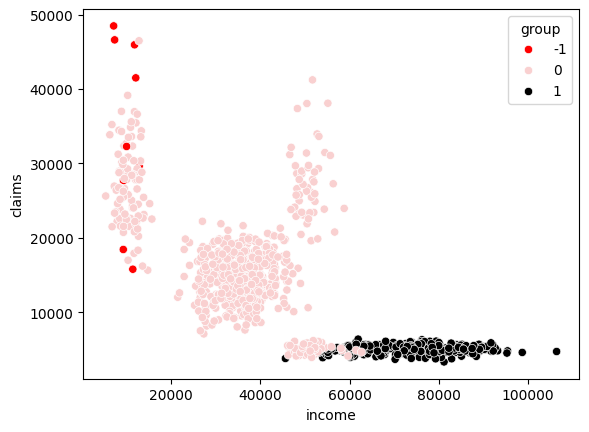

In [302]:
sns.scatterplot(x='income', y='claims', data=df_final_dbscan_pca,hue='group', palette=['red','#F9D0D0','black','blue'] )

Si bien hemos obtenido resultados interesantes, creamos que podemos mejorar aún más nuestra solución. Dado que hemos identificado la presencia de un grupo extremadamente pequeño, podemos iterar en los valores de `eps` y `min_samples` para ver si podemos mejorar la agrupación y reducir la presencia de grupos insignificantes. Vamos a explorar esta posibilidad y observar cómo afecta a nuestros resultados.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Número de clusters encontrados por DBSCAN: 4
Porcentaje de puntos considerados como ruido por DBSCAN: 2.4 %


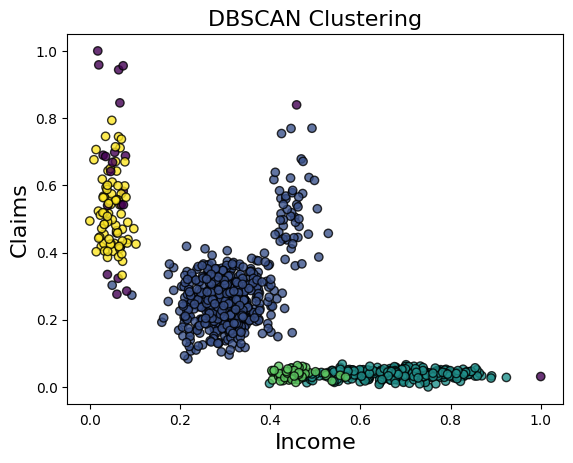

In [303]:
from sklearn.cluster import DBSCAN


eps = 0.07  # Definir el radio de la vecindad
min_samples = 9 # Definir el número mínimo de muestras en la vecindad

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels_dbscan_pca1 = dbscan.fit_predict(df_pca)


# Número de clusters encontrados por DBSCAN
n_clusters_dbscan = len(set(labels_dbscan_pca1)) - (1 if -1 in labels_dbscan_pca1 else 0)
print("Número de clusters encontrados por DBSCAN:", n_clusters_dbscan)

# Porcentaje de puntos considerados como ruido por DBSCAN
percent_noise = list(labels_dbscan_pca1).count(-1) / len(labels_dbscan_pca1) * 100
print("Porcentaje de puntos considerados como ruido por DBSCAN:", percent_noise, "%")

plt.scatter(df_norm['income'], df_norm['claims'], c=labels_dbscan_pca1, cmap='viridis', alpha=0.8, edgecolor='k')
plt.xlabel('Income', fontsize=16)
plt.ylabel('Claims', fontsize=16)
plt.title('DBSCAN Clustering', fontsize=16)

plt.show()



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='income', ylabel='claims'>

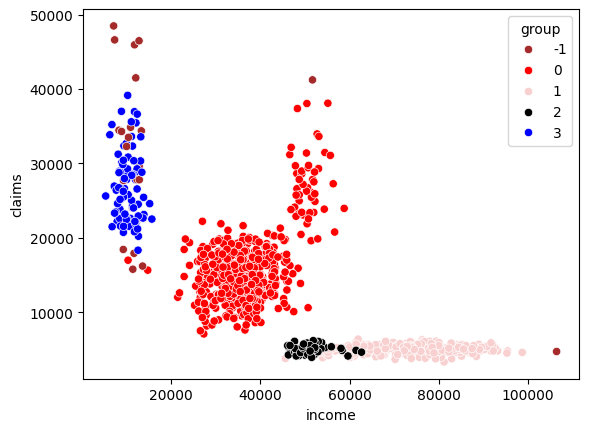

In [304]:
df_final_dbscan_pca1=df_data.copy()
df_final_dbscan_pca1['group']=labels_dbscan_pca1
df_final_dbscan_pca1.head(10)
sns.scatterplot(x='income', y='claims', data=df_final_dbscan_pca1,hue='group', palette=['brown','red','#F9D0D0','black','blue'] )

Ahora que hemos refinado nuestros parámetros y obtenido un resultado más prometedor, es hora de comparar este modelo con los resultados anteriores.

### Gráficas finales del problema para analizar (PCA & DBScan)




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


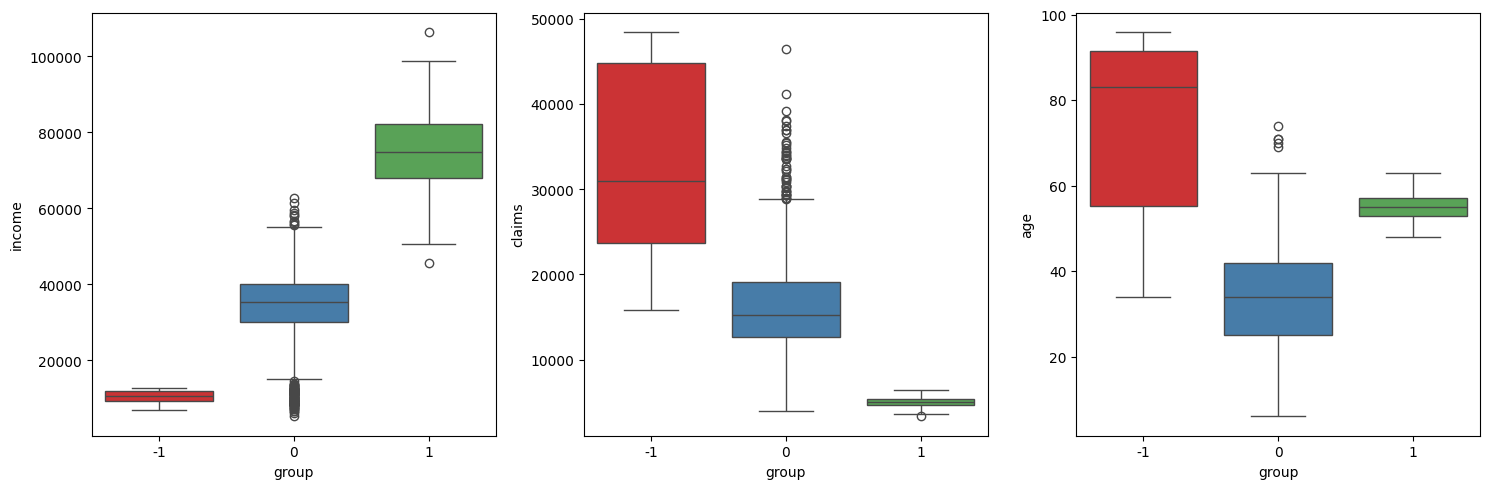

In [305]:
# Crear los boxplots con la asignación de hue y legend=False
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(x='group', y='income', data=df_final_dbscan_pca, ax=ax[0], hue='group', palette='Set1', legend=False)
sns.boxplot(x='group', y='claims', data=df_final_dbscan_pca, ax=ax[1], hue='group', palette='Set1', legend=False)
sns.boxplot(x='group', y='age', data=df_final_dbscan_pca, ax=ax[2], hue='group', palette='Set1', legend=False)
fig.tight_layout()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


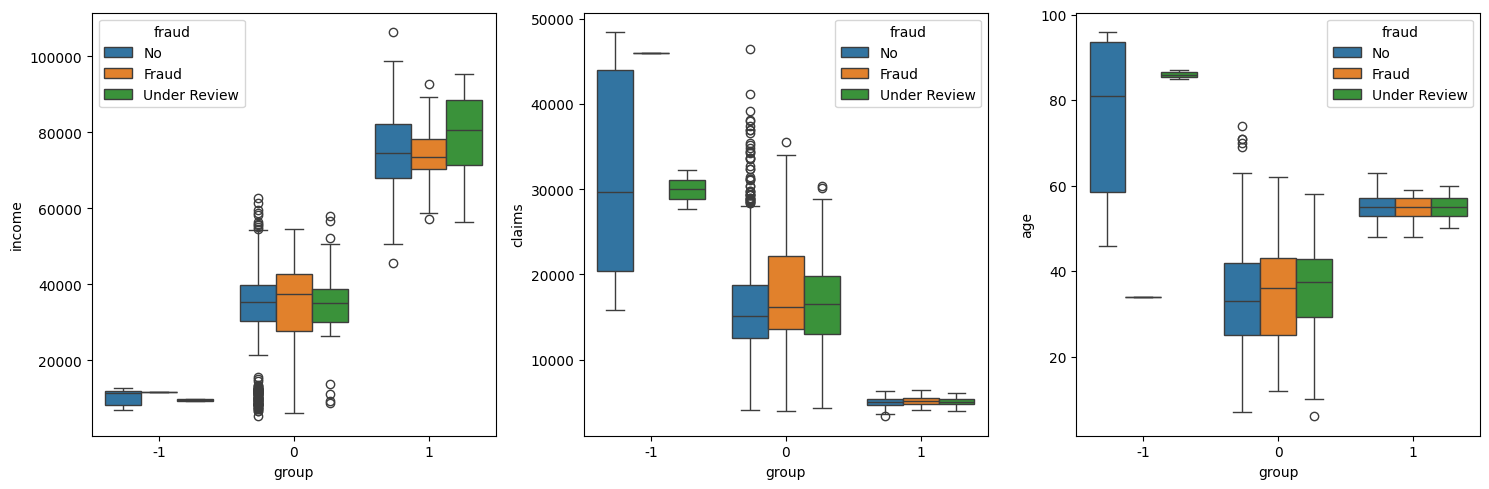

In [306]:
fig,ax=plt.subplots(1,3,figsize=(15,5))
sns.boxplot(x='group', y='income', hue='fraud',data=df_final_dbscan_pca,ax=ax[0])
sns.boxplot(x='group', y='claims', hue='fraud',data=df_final_dbscan_pca,ax=ax[1])
sns.boxplot(x='group', y='age', hue='fraud',data=df_final_dbscan_pca,ax=ax[2])
fig.tight_layout()

### Veamos la tercera comparación de algoritmos

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-307-7539decb53e4>:11: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x='income', y='claims', data=df_final_dbscan,hue='group', palette=['red','black','#F9D0D0','blue'], ax=ax[2] )


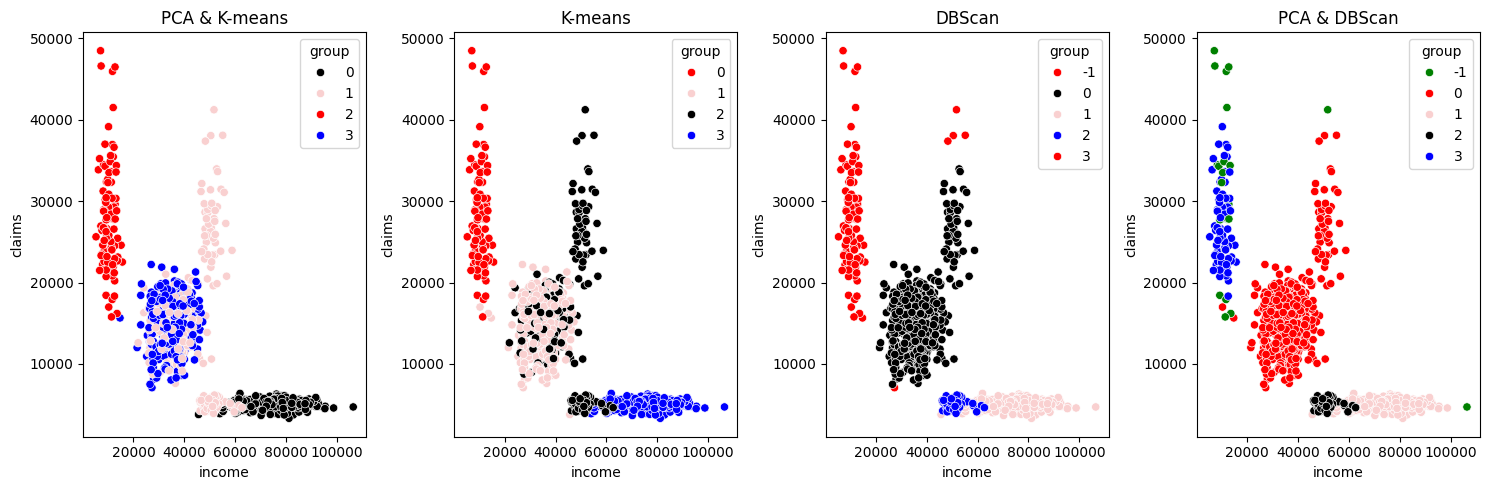

In [307]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))

# Gráfica PCA & K-means
sns.scatterplot(x='income', y='claims', data=df_final_pca, hue='group', palette=['black','#F9D0D0','red','blue'], ax=ax[0])
ax[0].set_title('PCA & K-means')

# Gráfica K-means
sns.scatterplot(x='income', y='claims', data=df_final, hue='group', palette=['red','#F9D0D0','black','blue'], ax=ax[1])
ax[1].set_title('K-means')

sns.scatterplot(x='income', y='claims', data=df_final_dbscan,hue='group', palette=['red','black','#F9D0D0','blue'], ax=ax[2] )
ax[2].set_title('DBScan')

sns.scatterplot(x='income', y='claims', data=df_final_dbscan_pca1,hue='group', palette=['green','red','#F9D0D0','black','blue'],ax=ax[3] )
ax[3].set_title('PCA & DBScan')

fig.tight_layout()
plt.show()

## Reglas de Asociacion

Exploremos como podemos abordar este problema con las reglas de asociación. Recordemos que:

Las reglas de asociación son un conjunto de técnicas utilizadas para descubrir relaciones interesantes entre variables en grandes conjuntos de datos. Uno de los algoritmos más comunes para encontrar estas reglas es el algoritmo Apriori. Este algoritmo se basa en el principio de que si un conjunto de artículos es frecuente, entonces todos sus subconjuntos también lo son. La idea es generar candidatos de reglas frecuentes y luego filtrarlos para obtener las reglas más relevantes según ciertos criterios, como el soporte y la confianza.

In [308]:
data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'income': [35750.95, 24078.27, 39241.52, 33248.31, 38649.96],
 'age': [42, 19, 37, 26, 54],
 'claims': [9518.95, 19354.23, 13056.04, 19238.37, 14427.42],
 'fraud': ['Under Review', 'No', 'Fraud', 'No', 'No']}

In [309]:
df_data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


case_id    income  age sex  approval         fraud    claims
0      59982  35750.95   42   M  Approved  Under Review   9518.95
1      87249  24078.27   19   M    Denied            No  19354.23
2      50406  39241.52   37   M    Denied         Fraud  13056.04
3      59391  33248.31   26   M  Approved            No  19238.37
4      96622  38649.96   54   M  Approved            No  14427.42
..       ...       ...  ...  ..       ...           ...       ...
995    96947  11353.88   81   M  Approved            No  15781.10
996    87668   8799.08   37   M  Approved            No  37004.41
997    39658  13143.52   35   M  Approved         Fraud  33580.79
998    77914   9473.25   36   F    Denied            No  27975.41
999    97965  11818.86   36   F  Approved         Fraud  22199.07

[1000 rows x 7 columns]

In [310]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Seleccionar las columnas relevantes
data = df_data[['income', 'age', 'claims', 'fraud']]

df_claims_list = []
for _, row in data.iterrows():
    claims = []
    claims.append('income=' + str(row['income']))
    claims.append('age=' + str(row['age']))
    claims.append('claims=' + str(row['claims']))
    claims.append('fraud=' + str(row['fraud']))
    df_claims_list.append(claims)

# Utilizar TransactionEncoder para codificar los datos en una matriz de ceros y unos
te = TransactionEncoder()
te_ary = te.fit(df_claims_list).transform(df_claims_list)
df_apriori = pd.DataFrame(te_ary, columns=te.columns_) #0.01

# Aplicar el algoritmo Apriori para encontrar conjuntos de elementos frecuentes
frequent_itemsets = apriori(df_apriori, min_support=0.01, use_colnames=True)


# Generar reglas de asociación a partir de los conjuntos de elementos frecuentes
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1) #0.1

# Imprimir el DataFrame rules para verificar su estructura
print(rules)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   antecedents consequents  antecedent support  consequent support  support  \
0     (age=18)  (fraud=No)               0.023                0.83    0.022   
1     (age=19)  (fraud=No)               0.024                0.83    0.021   
2     (age=20)  (fraud=No)               0.021                0.83    0.017   
3     (age=21)  (fraud=No)               0.019                0.83    0.016   
4     (age=22)  (fraud=No)               0.016                0.83    0.014   
5     (age=23)  (fraud=No)               0.015                0.83    0.013   
6     (age=25)  (fraud=No)               0.018                0.83    0.015   
7     (age=26)  (fraud=No)               0.025                0.83    0.023   
8     (age=27)  (fraud=No)               0.016                0.83    0.015   
9     (age=28)  (fraud=No)               0.016                0.83    0.014   
10    (age=30)  (fraud=No)               0.014                0.83    0.012   
11    (age=31)  (fraud=No)               0.033      

#### Algoritmo agrupando variabels numericas en categoricas para mejorar resultados

In [311]:
df_apriori

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


age=10  age=11  age=12  age=13  age=14  age=15  age=16  age=17  age=18  \
0     False   False   False   False   False   False   False   False   False   
1     False   False   False   False   False   False   False   False   False   
2     False   False   False   False   False   False   False   False   False   
3     False   False   False   False   False   False   False   False   False   
4     False   False   False   False   False   False   False   False   False   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
995   False   False   False   False   False   False   False   False   False   
996   False   False   False   False   False   False   False   False   False   
997   False   False   False   False   False   False   False   False   False   
998   False   False   False   False   False   False   False   False   False   
999   False   False   False   False   False   False   False   False   False   

     age=19  ...  income=9473.25  income=95305.28  income=95439.66  \
0     False  ...           False            False            False   
1      True  ...           False            False            False   
2     False  ...           False            False            False   
3     False  ...           False            False            False   
4     False  ...           False            False            False   
..      ...  ...             ...              ...              ...   
995   False  ...           False            False            False   
996   False  ...           False            False            False   
997   False  ...           False            False            False   
998   False  ...            True            False            False   
999   False  ...           False            False            False   

     income=9580.19  income=9713.2  income=9869.13  income=98740.57  \
0             False          False           False            False   
1             False          False           False            False   
2             False          False           False            False   
3             False          False           False            False   
4             False          False           False            False   
..              ...            ...             ...              ...   
995           False          False           False            False   
996           False          False           False            False   
997           False          False           False            False   
998           False          False           False            False   
999           False          False           False            False   

     income=9897.26  income=9954.5  income=9959.24  
0             False          False           False  
1             False          False           False  
2             False          False           False  
3             False          False           False  
4             False          False           False  
..              ...            ...             ...  
995           False          False           False  
996           False          False           False  
997           False          False           False  
998           False          False           False  
999           False          False           False  

[1000 rows x 2072 columns]

In [312]:
df_apriori

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


age=10  age=11  age=12  age=13  age=14  age=15  age=16  age=17  age=18  \
0     False   False   False   False   False   False   False   False   False   
1     False   False   False   False   False   False   False   False   False   
2     False   False   False   False   False   False   False   False   False   
3     False   False   False   False   False   False   False   False   False   
4     False   False   False   False   False   False   False   False   False   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
995   False   False   False   False   False   False   False   False   False   
996   False   False   False   False   False   False   False   False   False   
997   False   False   False   False   False   False   False   False   False   
998   False   False   False   False   False   False   False   False   False   
999   False   False   False   False   False   False   False   False   False   

     age=19  ...  income=9473.25  income=95305.28  income=95439.66  \
0     False  ...           False            False            False   
1      True  ...           False            False            False   
2     False  ...           False            False            False   
3     False  ...           False            False            False   
4     False  ...           False            False            False   
..      ...  ...             ...              ...              ...   
995   False  ...           False            False            False   
996   False  ...           False            False            False   
997   False  ...           False            False            False   
998   False  ...            True            False            False   
999   False  ...           False            False            False   

     income=9580.19  income=9713.2  income=9869.13  income=98740.57  \
0             False          False           False            False   
1             False          False           False            False   
2             False          False           False            False   
3             False          False           False            False   
4             False          False           False            False   
..              ...            ...             ...              ...   
995           False          False           False            False   
996           False          False           False            False   
997           False          False           False            False   
998           False          False           False            False   
999           False          False           False            False   

     income=9897.26  income=9954.5  income=9959.24  
0             False          False           False  
1             False          False           False  
2             False          False           False  
3             False          False           False  
4             False          False           False  
..              ...            ...             ...  
995           False          False           False  
996           False          False           False  
997           False          False           False  
998           False          False           False  
999           False          False           False  

[1000 rows x 2072 columns]

In [322]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Sample data frame

df_data_groups = pd.DataFrame(data)

# Create bins for income, age, and claims
df_data_groups['income_bin'] = pd.cut(df_data_groups['income'], bins=[0, 20000, 40000, 60000, 120000], labels=['Low', 'Medium', 'High', 'Very High'])
df_data_groups['age_bin'] = pd.cut(df_data_groups['age'], bins=[0, 20, 40, 60, 100], labels=['Young', 'Middle-aged', 'Senior', 'Super-senior'])
df_data_groups['claims_bin'] = pd.cut(df_data_groups['claims'], bins=[0, 10000, 20000, 30000, 70000], labels=['Low', 'Medium', 'High', 'Very High'])

# Create the list of transactions for apriori
df_claims_list = []
for _, row in df_data_groups.iterrows():
    claims = []
    claims.append('income=' + str(row['income_bin']))
    claims.append('age=' + str(row['age_bin']))
    claims.append('claims=' + str(row['claims_bin']))
    claims.append('fraud=' + str(row['fraud']))
    df_claims_list.append(claims)

# Use TransactionEncoder to encode the data into a binary matrix
te = TransactionEncoder()
te_ary = te.fit(df_claims_list).transform(df_claims_list)
df_apriori = pd.DataFrame(te_ary, columns=te.columns_)

# Apply the Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(df_apriori, min_support=0.01, use_colnames=True)

# Generate association rules from the frequent itemsets
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)

# Print the DataFrame rules to verify its structure
print(rules)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                                   antecedents  \
0                            (age=Middle-aged)   
1                                (claims=High)   
2                            (age=Middle-aged)   
3                              (claims=Medium)   
4                           (claims=Very High)   
..                                         ...   
543  (age=Young, claims=Medium, income=Medium)   
544                      (fraud=No, age=Young)   
545                 (age=Young, claims=Medium)   
546                 (age=Young, income=Medium)   
547                                (age=Young)   

                                  consequents  antecedent support  \
0                               (claims=High)               0.381   
1                           (age=Middle-aged)               0.111   
2                             (claims=Medium)               0.381   
3                           (age=Middle-aged)               0.472   
4                           (age=Middle-aged)         

### Expliquemos un poco el primer resultado

- **antecedents**: (`age=18`) es el antecedente de la regla de asociación. Indica que esta regla se activa cuando la característica age tiene el valor 18.

- **consequents**: (`fraud=No`) es el consecuente de la regla de asociación. Indica que cuando el antecedente se cumple (cuando `age=18`), el consecuente fraud=No también se cumple.

- **support**: El soporte de la regla es 0.023, lo que significa que el 2.3% de las transacciones en el conjunto de datos contienen tanto `age=18` como `fraud=No`.

- **confidence**: La confianza de la regla es 0.83 (o 83%), lo que significa que el 83% de las transacciones que contienen `age=18` también contienen `fraud=No`.

- **lift**: El lift de la regla es 1.152436, lo que indica que es 1.152436 veces más probable que fraud=No ocurra dado que `age=18` está presente, en comparación con si fueran independientes. Un lift mayor que 1 indica una asociación positiva entre los elementos.

- **leverage**: La ganancia (leverage) de la regla es 0.00291, que es una medida de cuánto más ocurre la combinación de antecedente y consecuente juntos en comparación con lo que se esperaría si fueran independientes.

- **conviction**: La convicción de la regla es 3.91, que es una medida de la dependencia entre el antecedente y el consecuente. Una convicción mayor que 1 indica una dependencia significativa.

- **zhangs_metric**: La métrica de Zhang es 0.135387, que es otra medida de la dependencia entre el antecedente y el consecuente. Valores más altos indican una mayor dependencia.

Esta regla de asociación nos dice que cuando `age=18`, es muy probable (confidencia alta) que `fraud=No` también esté presente, y esta asociación es más fuerte de lo que se esperaría al azar (lift mayor que 1).

### Verifiquemos que estén todos los datos de Fraud

In [324]:
df_claims_list

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['income=Medium', 'age=Senior', 'claims=Low', 'fraud=Under Review'],
 ['income=Medium', 'age=Young', 'claims=Medium', 'fraud=No'],
 ['income=Medium', 'age=Middle-aged', 'claims=Medium', 'fraud=Fraud'],
 ['income=Medium', 'age=Middle-aged', 'claims=Medium', 'fraud=No'],
 ['income=Medium', 'age=Senior', 'claims=Medium', 'fraud=No'],
 ['income=Medium', 'age=Senior', 'claims=Medium', 'fraud=No'],
 ['income=Medium', 'age=Senior', 'claims=Medium', 'fraud=No'],
 ['income=High', 'age=Senior', 'claims=Medium', 'fraud=No'],
 ['income=Medium', 'age=Middle-aged', 'claims=Medium', 'fraud=No'],
 ['income=Medium', 'age=Middle-aged', 'claims=Medium', 'fraud=No'],
 ['income=Medium', 'age=Senior', 'claims=Medium', 'fraud=No'],
 ['income=Medium', 'age=Middle-aged', 'claims=Medium', 'fraud=No'],
 ['income=High', 'age=Middle-aged', 'claims=Medium', 'fraud=No'],
 ['income=High', 'age=Senior', 'claims=High', 'fraud=No'],
 ['income=Medium', 'age=Middle-aged', 'claims=Medium', 'fraud=No'],
 ['income=Medium', 

### ¿Por qué solo tenemos `fraud=No`?

La ausencia de otras categorías de la variable fraud, como `fraud=Under Review` o `fraud=Fraud`, en las reglas de asociación podría indicar varias cosas:

1. Distribución de los datos: Podría ser que en los datos proporcionados, la mayoría de las transacciones tengan la etiqueta fraud=No, lo que hace que las asociaciones con otras categorías sean menos comunes o menos significativas desde el punto de vista del algoritmo de asociación.

2. Umbral de soporte y confianza: El conjunto de reglas de asociación generado podría estar sujeto a un umbral de soporte y confianza que solo selecciona las reglas más frecuentes y confiables. Si las otras categorías de fraud tienen una frecuencia o una relación de asociación menor, podrían no cumplir con estos umbrales y, por lo tanto, no aparecer en las reglas generadas.

3. Naturaleza de los datos: Dependiendo del dominio y la naturaleza de los datos, puede que la asociación entre las otras categorías de fraud y las variables de entrada (como `age`) sea más débil o menos común en comparación con `fraud=No`, lo que resulta en su ausencia en las reglas de asociación.

Es importante revisar la distribución de las categorías de la variable fraud en los datos y ajustar los parámetros del algoritmo de asociación según sea necesario para capturar todas las asociaciones relevantes en los datos.

Revisemos que si hay asociaciones con poca confidencia con las siguientes lineas de codigo:

In [325]:
filtered_rules_fp = rules[(rules['confidence'] < 0.4)]

print("Reglas de Asociación filtradas:")
print(filtered_rules_fp)

Reglas de Asociación filtradas:
                 antecedents                               consequents  \
0          (age=Middle-aged)                             (claims=High)   
4         (claims=Very High)                         (age=Middle-aged)   
5          (age=Middle-aged)                             (fraud=Fraud)   
6              (fraud=Fraud)                         (age=Middle-aged)   
8                 (fraud=No)                         (age=Middle-aged)   
..                       ...                                       ...   
538  (income=High, fraud=No)                   (claims=Low, age=Young)   
539              (age=Young)       (claims=Low, income=High, fraud=No)   
540            (income=High)         (claims=Low, fraud=No, age=Young)   
544    (fraud=No, age=Young)            (claims=Medium, income=Medium)   
547              (age=Young)  (fraud=No, claims=Medium, income=Medium)   

     antecedent support  consequent support  support  confidence      lift  \
0

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Parece que no se han encontrado asociaciones para los valores de `fraud=Fraud`. Sin embargo, a partir de las asociaciones mostradas anteriormente, podemos inferir la posibilidad de escenarios poco probables en los que se detecte fraude en función de la edad. Esto sugiere que aunque no se han identificado asociaciones directas con la categoría `'fraud=Fraud'` y los valores de `claims`. Por otro lado, la combinación de otras características, como la edad, puede ser indicativa de la presencia de fraude en ciertos casos.